# Recommendation System - Thesis

### Author - Virginia Kostara

The following implementation has to do with a recommendation engine based on a sales dataset referring to the sales history of a popular retail chain. The goal is this implementation to be applied in a scan & go web app that can be found in selected physical stores. <b>Our intention is to make product recommendations for randomly chosen orders based on the order profile.</b> 

## Table of Contents:

1. [Imports](#1.-Imports)      
2. [Pre-process](#2.-Pre-process)   
3. [A-priori](#3.-A-priori)   
4. [Feature Engineering](#4.-Feature-Engineering)
5. [Model Creation](#5.-Model-Creation)
6. [Select k best recommendations](#6.-Select-k-best-recommendations)
7. [Citations](#7.-Citations)

## 1. Imports

In [801]:
import pandas as pd
import numpy as np

In [802]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [803]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## 2. Pre-process

#### In this step, we want to understand our dataset and convert it into a more readable and easy-to-handle version.

We read our dataset by specifing the data type of each column. The 6 basic columns ('completion_date','product_identifier','order_id','item_name','price','store_name') were just expected as we are dealing with a sales dataset. The 'extra data' column contains a lot of details and some of them are out of our interest. We will investigate this later.

General note: All the information we have in our poccession can be found in this core dataset. Unfortunately, as we can see, we have no information about customers' history and, therefore, we do not know which order belongs to each customer. 

In [804]:
df = pd.read_csv("data.csv", dtype={'completion_date': str,'product_identifier': str,
                                                      'order_id': str,'item_name':str, 'price':float, 'store_name':str,'extra_data': str, "Record Count":int}, encoding='latin')
df

,Unnamed: 0,completion_date,product_identifier,order_id,item_name,price,store_name,extra_data,Record Count
0,0,"Jan 2, 2023, 2:41:44/PM",4550002814502,8598b01a-c4ef-47af-9caa-2d4a69b50a05,Refill Gel Ink Ballpoint Pen 0.38Mm,0.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2
1,1,"Jan 6, 2023, 12:39:08/PM",4550344303870,a9debaf1-b6a3-4c57-ad6f-bf566b0328aa,Polycarbonate Double Ruler Mini,2.50,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2
2,2,"Jan 9, 2023, 4:56:54/PM",4550002794118,a64a70b8-357f-471c-99d7-ad57f96eef7b,Smooth Gel Ink Ballpoint Pen 0.5Mm,1.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2
3,3,"Jan 1, 2023, 12:14:32/PM",4550512094890,aad4e556-98be-4f71-afae-458d0469915f,Lyocell Blend Slippers,12.95,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1
4,4,"Jan 1, 2023, 12:14:32/PM",4550512255277,aad4e556-98be-4f71-afae-458d0469915f,Right Angle Top Loose 3 Layer Socks,3.50,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1
...,...,...,...,...,...,...,...,...,...
95425,95425,"Mar 31, 2023, 6:43:53/PM",4550344831847,4f32bd3d-a215-4a58-97ef-2806ac62645d,Cleaning System Microfiber Floor Mop,3.95,TOTTENHAM COURT ROAD,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1
95426,95426,"Mar 31, 2023, 6:45:02/PM",5055473366851,1e60fa1f-35cf-4cb0-af43-34e929dacfaa,Tin Candle - Hinoki Wood,3.95,OXFORD STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1
95427,95427,"Mar 31, 2023, 6:45:59/PM",5055473366851,3812f96e-b50c-4f3f-8b43-ea8b5c1647d3,Tin Candle - Hinoki Wood,3.95,OXFORD STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1
95428,95428,"Mar 31, 2023, 6:54:57/PM",4550002796860,e7e5806e-f2a4-4fd0-b04d-41cc39ec977c,Gel Ink Ballpoint Pen 0.5Mm,1.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1


As part of the pre-process, we delete unnecessary columns and rows.

In [805]:
df = df[['completion_date','product_identifier','order_id','item_name','price','store_name','extra_data','Record Count']]
df

,completion_date,product_identifier,order_id,item_name,price,store_name,extra_data,Record Count
0,"Jan 2, 2023, 2:41:44/PM",4550002814502,8598b01a-c4ef-47af-9caa-2d4a69b50a05,Refill Gel Ink Ballpoint Pen 0.38Mm,0.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2
1,"Jan 6, 2023, 12:39:08/PM",4550344303870,a9debaf1-b6a3-4c57-ad6f-bf566b0328aa,Polycarbonate Double Ruler Mini,2.50,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2
2,"Jan 9, 2023, 4:56:54/PM",4550002794118,a64a70b8-357f-471c-99d7-ad57f96eef7b,Smooth Gel Ink Ballpoint Pen 0.5Mm,1.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2
3,"Jan 1, 2023, 12:14:32/PM",4550512094890,aad4e556-98be-4f71-afae-458d0469915f,Lyocell Blend Slippers,12.95,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1
4,"Jan 1, 2023, 12:14:32/PM",4550512255277,aad4e556-98be-4f71-afae-458d0469915f,Right Angle Top Loose 3 Layer Socks,3.50,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1
...,...,...,...,...,...,...,...,...
95425,"Mar 31, 2023, 6:43:53/PM",4550344831847,4f32bd3d-a215-4a58-97ef-2806ac62645d,Cleaning System Microfiber Floor Mop,3.95,TOTTENHAM COURT ROAD,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1
95426,"Mar 31, 2023, 6:45:02/PM",5055473366851,1e60fa1f-35cf-4cb0-af43-34e929dacfaa,Tin Candle - Hinoki Wood,3.95,OXFORD STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1
95427,"Mar 31, 2023, 6:45:59/PM",5055473366851,3812f96e-b50c-4f3f-8b43-ea8b5c1647d3,Tin Candle - Hinoki Wood,3.95,OXFORD STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1
95428,"Mar 31, 2023, 6:54:57/PM",4550002796860,e7e5806e-f2a4-4fd0-b04d-41cc39ec977c,Gel Ink Ballpoint Pen 0.5Mm,1.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1


In the following row we detect invalid characters. We just delete it.

In [806]:
df['extra_data'][70416]

'{"vat_rate": "22.00", "categories": ["Casa", "Cucina E Sala DA Pranzo", "Contenitori IN Vetro"], "inventory_service": {"id": "640d8899cf5b10219f3ae3d4", "size": "'

In [807]:
df = df.drop(index=70416)
df

,completion_date,product_identifier,order_id,item_name,price,store_name,extra_data,Record Count
0,"Jan 2, 2023, 2:41:44/PM",4550002814502,8598b01a-c4ef-47af-9caa-2d4a69b50a05,Refill Gel Ink Ballpoint Pen 0.38Mm,0.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2
1,"Jan 6, 2023, 12:39:08/PM",4550344303870,a9debaf1-b6a3-4c57-ad6f-bf566b0328aa,Polycarbonate Double Ruler Mini,2.50,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2
2,"Jan 9, 2023, 4:56:54/PM",4550002794118,a64a70b8-357f-471c-99d7-ad57f96eef7b,Smooth Gel Ink Ballpoint Pen 0.5Mm,1.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2
3,"Jan 1, 2023, 12:14:32/PM",4550512094890,aad4e556-98be-4f71-afae-458d0469915f,Lyocell Blend Slippers,12.95,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1
4,"Jan 1, 2023, 12:14:32/PM",4550512255277,aad4e556-98be-4f71-afae-458d0469915f,Right Angle Top Loose 3 Layer Socks,3.50,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1
...,...,...,...,...,...,...,...,...
95425,"Mar 31, 2023, 6:43:53/PM",4550344831847,4f32bd3d-a215-4a58-97ef-2806ac62645d,Cleaning System Microfiber Floor Mop,3.95,TOTTENHAM COURT ROAD,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1
95426,"Mar 31, 2023, 6:45:02/PM",5055473366851,1e60fa1f-35cf-4cb0-af43-34e929dacfaa,Tin Candle - Hinoki Wood,3.95,OXFORD STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1
95427,"Mar 31, 2023, 6:45:59/PM",5055473366851,3812f96e-b50c-4f3f-8b43-ea8b5c1647d3,Tin Candle - Hinoki Wood,3.95,OXFORD STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1
95428,"Mar 31, 2023, 6:54:57/PM",4550002796860,e7e5806e-f2a4-4fd0-b04d-41cc39ec977c,Gel Ink Ballpoint Pen 0.5Mm,1.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1


We delete all the rows that represent the sale of small paper bags as we are not supposed to recommend these products. To clarify, the purpose of these bags is just to store and transfer the other purchased products included in an order.

In [808]:
df = df[df.product_identifier != '0299417000004']
df = df[df.product_identifier != '299417000004']
df

,completion_date,product_identifier,order_id,item_name,price,store_name,extra_data,Record Count
0,"Jan 2, 2023, 2:41:44/PM",4550002814502,8598b01a-c4ef-47af-9caa-2d4a69b50a05,Refill Gel Ink Ballpoint Pen 0.38Mm,0.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2
1,"Jan 6, 2023, 12:39:08/PM",4550344303870,a9debaf1-b6a3-4c57-ad6f-bf566b0328aa,Polycarbonate Double Ruler Mini,2.50,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2
2,"Jan 9, 2023, 4:56:54/PM",4550002794118,a64a70b8-357f-471c-99d7-ad57f96eef7b,Smooth Gel Ink Ballpoint Pen 0.5Mm,1.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2
3,"Jan 1, 2023, 12:14:32/PM",4550512094890,aad4e556-98be-4f71-afae-458d0469915f,Lyocell Blend Slippers,12.95,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1
4,"Jan 1, 2023, 12:14:32/PM",4550512255277,aad4e556-98be-4f71-afae-458d0469915f,Right Angle Top Loose 3 Layer Socks,3.50,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1
...,...,...,...,...,...,...,...,...
95425,"Mar 31, 2023, 6:43:53/PM",4550344831847,4f32bd3d-a215-4a58-97ef-2806ac62645d,Cleaning System Microfiber Floor Mop,3.95,TOTTENHAM COURT ROAD,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1
95426,"Mar 31, 2023, 6:45:02/PM",5055473366851,1e60fa1f-35cf-4cb0-af43-34e929dacfaa,Tin Candle - Hinoki Wood,3.95,OXFORD STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1
95427,"Mar 31, 2023, 6:45:59/PM",5055473366851,3812f96e-b50c-4f3f-8b43-ea8b5c1647d3,Tin Candle - Hinoki Wood,3.95,OXFORD STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1
95428,"Mar 31, 2023, 6:54:57/PM",4550002796860,e7e5806e-f2a4-4fd0-b04d-41cc39ec977c,Gel Ink Ballpoint Pen 0.5Mm,1.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1


After these pre-process actions, several rows were deleted and, as a result, the shape of the dataframe has changed. As it is very likely that the shape will change several times later on, we would like to keep the initial index of each row. That would propably work as a point of reference for us.  

In [809]:
df.reset_index(inplace=True)
df

,index,completion_date,product_identifier,order_id,item_name,price,store_name,extra_data,Record Count
0,0,"Jan 2, 2023, 2:41:44/PM",4550002814502,8598b01a-c4ef-47af-9caa-2d4a69b50a05,Refill Gel Ink Ballpoint Pen 0.38Mm,0.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2
1,1,"Jan 6, 2023, 12:39:08/PM",4550344303870,a9debaf1-b6a3-4c57-ad6f-bf566b0328aa,Polycarbonate Double Ruler Mini,2.50,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2
2,2,"Jan 9, 2023, 4:56:54/PM",4550002794118,a64a70b8-357f-471c-99d7-ad57f96eef7b,Smooth Gel Ink Ballpoint Pen 0.5Mm,1.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2
3,3,"Jan 1, 2023, 12:14:32/PM",4550512094890,aad4e556-98be-4f71-afae-458d0469915f,Lyocell Blend Slippers,12.95,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1
4,4,"Jan 1, 2023, 12:14:32/PM",4550512255277,aad4e556-98be-4f71-afae-458d0469915f,Right Angle Top Loose 3 Layer Socks,3.50,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1
...,...,...,...,...,...,...,...,...,...
89677,95425,"Mar 31, 2023, 6:43:53/PM",4550344831847,4f32bd3d-a215-4a58-97ef-2806ac62645d,Cleaning System Microfiber Floor Mop,3.95,TOTTENHAM COURT ROAD,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1
89678,95426,"Mar 31, 2023, 6:45:02/PM",5055473366851,1e60fa1f-35cf-4cb0-af43-34e929dacfaa,Tin Candle - Hinoki Wood,3.95,OXFORD STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1
89679,95427,"Mar 31, 2023, 6:45:59/PM",5055473366851,3812f96e-b50c-4f3f-8b43-ea8b5c1647d3,Tin Candle - Hinoki Wood,3.95,OXFORD STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1
89680,95428,"Mar 31, 2023, 6:54:57/PM",4550002796860,e7e5806e-f2a4-4fd0-b04d-41cc39ec977c,Gel Ink Ballpoint Pen 0.5Mm,1.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1


It is now time to investigate the "extra_data" column. We want to extract the info stored in this column into multiple columns, so as to understand its content. We will do so by taking advantage of the current json format that consists of several key-value pairs.

In [810]:
df_extra = df['extra_data'].astype(str).str.strip('{}').str.split(', ', expand=True)

In [811]:
df_extra.head(40)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
0,"""vat_rate"": ""20.00""","""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""inventory_service"": {""id"": ""63b137579eac5c622...","""size"": ""*""","""addon"": null","""theme"": ""invariant""","""colour"": {""hex"": ""#000080""","""name"": ""Navy""}","""images"": [""https://www.muji.eu/img/prd/0180/4...","""variant"": ""*""","""createdAt"": ""2023-01-01T07:33:45.993Z""","""updatedAt"": ""2023-01-01T07:33:45.993Z""","""categories"": [{""id"": ""63b137569eac5c55ba459e09""","""name"": ""Stationery""}","{""id"": ""63b137569eac5cfc8c459e54""","""name"": ""Pens & Pencils""}","{""id"": ""63b137569eac5c8032459ec0""","""name"": ""Gel Pens""}]","""addonGroups"": []","""itemVitalId"": ""63b137579eac5ca2bb484ca7""","""buyingGuidance"": {}","""poslogGuidance"": {}","""pricingGuidance"": {""excludingVat"": ""0.79""","""includingVat"": ""0.95""","""vatPercentage"": ""20.00""}}","""price_without_vat"": ""0.79""","""sent_product_identifier"": ""4550002814502""",None,None,None,None
1,"""vat_rate"": ""20.00""","""categories"": [""Stationery""","""Organisation""","""Office Supplies""]","""inventory_service"": {""id"": ""63b7cee2e39d1c077...","""size"": null","""addon"": null","""theme"": ""invariant""","""colour"": null","""images"": [""https://www.muji.eu/img/prd/0180/4...","""variant"": ""*""","""createdAt"": ""2023-01-06T07:33:56.394Z""","""updatedAt"": ""2023-01-06T07:33:56.394Z""","""categories"": [{""id"": ""63b7cee0e39d1c6c31707776""","""name"": ""Stationery""}","{""id"": ""63b7cee0e39d1ca3717077c2""","""name"": ""Organisation""}","{""id"": ""63b7cee0e39d1cbc987077c3""","""name"": ""Office Supplies""}]","""addonGroups"": []","""itemVitalId"": ""63b7cee2e39d1ce50774d044""","""buyingGuidance"": {}","""poslogGuidance"": {}","""pricingGuidance"": {""excludingVat"": ""2.08""","""includingVat"": ""2.50""","""vatPercentage"": ""20.00""}}","""price_without_vat"": ""2.08""","""sent_product_identifier"": ""4550344303870""",None,None,None,None,None
2,"""vat_rate"": ""20.00""","""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""inventory_service"": {""id"": ""63bbc37587a497233...","""size"": ""*""","""addon"": null","""theme"": ""invariant""","""colour"": {""hex"": ""#000000""","""name"": ""Black""}","""images"": [""https://www.muji.eu/img/prd/0180/4...","""variant"": ""*""","""createdAt"": ""2023-01-09T07:34:16.099Z""","""updatedAt"": ""2023-01-09T07:34:16.099Z""","""categories"": [{""id"": ""63bbc37387a497984a680c83""","""name"": ""Stationery""}","{""id"": ""63bbc37387a497229e680ccd""","""name"": ""Pens & Pencils""}","{""id"": ""63bbc37387a49777e5680d39""","""name"": ""Gel Pens""}]","""addonGroups"": []","""itemVitalId"": ""63bbc37587a49748a16aba2c""","""buyingGuidance"": {}","""poslogGuidance"": {}","""pricingGuidance"": {""excludingVat"": ""1.62""","""includingVat"": ""1.95""","""vatPercentage"": ""20.00""}}","""price_without_vat"": ""1.62""","""sent_product_identifier"": ""4550002794118""",None,None,None,None
3,"""vat_rate"": ""20.00""","""categories"": [""Women""","""Footwear""","""Slippers""]","""inventory_service"": {""id"": ""63b137589eac5c23d...","""size"": ""M/23.5-25cm""","""addon"": null","""theme"": ""invariant""","""colour"": {""hex"": ""#fffeb6""","""name"": ""Light Beige""}","""images"": [""https://www.muji.eu/img/prd/0180/4...","""variant"": ""*""","""createdAt"": ""2023-01-01T07:33:46.083Z""","""updatedAt"": ""2023-01-01T07:33:46.083Z""","""categories"": [{""id"": ""63b137569eac5c4ff1459e37""","""name"": ""Women""}","{""id"": ""63b137569eac5cec92459e7e""","""name"": ""Footwear""}","{""id"": ""63b137569eac5c2641459e1d""","""name"": ""Slippers""}]","""addonGroups"": []","""itemVitalId"": ""63b137589eac5c32bb4a893e""","""buyingGuidance"": {}","""poslogGuidance"": {}","""pricingGuidance"": {""excludingVat"": ""10.79""","""includingVat"": ""12.95""","""vatPercentage"": ""20.00""}}","""price_without_vat

In [812]:
df_extra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89682 entries, 0 to 89681
Data columns (total 33 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       89682 non-null  object
 1   1       89682 non-null  object
 2   2       89682 non-null  object
 3   3       89682 non-null  object
 4   4       89682 non-null  object
 5   5       89682 non-null  object
 6   6       89682 non-null  object
 7   7       89173 non-null  object
 8   8       89117 non-null  object
 9   9       89117 non-null  object
 10  10      89117 non-null  object
 11  11      89117 non-null  object
 12  12      89117 non-null  object
 13  13      89117 non-null  object
 14  14      89117 non-null  object
 15  15      89117 non-null  object
 16  16      89117 non-null  object
 17  17      89117 non-null  object
 18  18      89117 non-null  object
 19  19      89117 non-null  object
 20  20      89117 non-null  object
 21  21      89117 non-null  object
 22  22      89116 non-null

By examining all these columns, we pay attention to 2 significant factors. Firstly, apart from the first 5 columns, the other ones are mainly consisted of incomplete key-value pairs, as the value is often missing. Secondly, there are several columns that seem to be out of interest in the scope of a recommendation engine. To make it clear, information about indicators such the color or the VAT percentage of an item are not supposed to help us make better or worse product recommendations. Therefore, we conclude, after thorough search, that the only columns that have a business value for us are the ones referring to the product taxonomy tree. For now, we just make a hypothesis that it would be reasonable to search for the product categories within a shopping basket, so as to make recommendations about it. We will test this hypothesis in practice in the sections below.

We add the 3 invaluable columns in our main dataframe. We make a linguistic check so as to get rid of inappropriate data entries.

In [813]:
df['cat1'] = df_extra[1]
df['cat2'] = df_extra[2]
df['cat3'] = df_extra[3]
df

,index,completion_date,product_identifier,order_id,item_name,price,store_name,extra_data,Record Count,cat1,cat2,cat3
0,0,"Jan 2, 2023, 2:41:44/PM",4550002814502,8598b01a-c4ef-47af-9caa-2d4a69b50a05,Refill Gel Ink Ballpoint Pen 0.38Mm,0.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]"
1,1,"Jan 6, 2023, 12:39:08/PM",4550344303870,a9debaf1-b6a3-4c57-ad6f-bf566b0328aa,Polycarbonate Double Ruler Mini,2.50,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2,"""categories"": [""Stationery""","""Organisation""","""Office Supplies""]"
2,2,"Jan 9, 2023, 4:56:54/PM",4550002794118,a64a70b8-357f-471c-99d7-ad57f96eef7b,Smooth Gel Ink Ballpoint Pen 0.5Mm,1.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]"
3,3,"Jan 1, 2023, 12:14:32/PM",4550512094890,aad4e556-98be-4f71-afae-458d0469915f,Lyocell Blend Slippers,12.95,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1,"""categories"": [""Women""","""Footwear""","""Slippers""]"
4,4,"Jan 1, 2023, 12:14:32/PM",4550512255277,aad4e556-98be-4f71-afae-458d0469915f,Right Angle Top Loose 3 Layer Socks,3.50,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1,"""categories"": [""Women""","""Underwear & Socks""","""Socks & Tights""]"
...,...,...,...,...,...,...,...,...,...,...,...,...
89677,95425,"Mar 31, 2023, 6:43:53/PM",4550344831847,4f32bd3d-a215-4a58-97ef-2806ac62645d,Cleaning System Microfiber Floor Mop,3.95,TOTTENHAM COURT ROAD,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1,"""categories"": [""Home""","""Utility""","""Cleaning""]"
89678,95426,"Mar 31, 2023, 6:45:02/PM",5055473366851,1e60fa1f-35cf-4cb0-af43-34e929dacfaa,Tin Candle - Hinoki Wood,3.95,OXFORD STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1,"""categories"": [""Home""","""Home Fragrance""","""Candles""]"
89679,95427,"Mar 31, 2023, 6:45:59/PM",5055473366851,3812f96e-b50c-4f3f-8b43-ea8b5c1647d3,Tin Candle - Hinoki Wood,3.95,OXFORD STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1,"""categories"": [""Home""","""Home Fragrance""","""Candles""]"
89680,95428,"Mar 31, 2023, 6:54:57/PM",4550002796860,e7e5806e-f2a4-4fd0-b04d-41cc39ec977c,Gel Ink Ballpoint Pen 0.5Mm,1.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]"


In [814]:
df = df[df['cat1'].str.match('"categories"')]

## 3. A-priori

#### In this step, we will get advantage of a popular algorithm which is mainly used for Market Basket Analysis. It belongs to the family of the Association Rules algorithms and is known for its frequent item set mining capabilities. In our case, we know the category of each product. So, it is worth it to test the A-priori algorithm and see whether there are some product categories that go together in a significant amount of shopping baskets. In a way, this may help us build a category-based recommendation engine.

Based on the previous markdown cell, we would like to implement an one-hot encoding procedure related to the category of each product. In other words, we will create n new columns about all the product categories that exist. If a product belongs to a specific product category, the value in the corresponding row and column would be equal to 1. Otherwise, the value would be equal to 0. It is essential to state that the product categories follow a product taxonomy schema. That means that there are 3 cases: 1. a product belongs to 3 category families (e.g. Women -> Footwear -> Slippers) 2. a product belongs to 2 category families (e.g. Bags & Shoes -> Tote Bags) 3. a product belongs to just one category family (e.g. Other). In this dataset, the vast majority of the products belong to 3 category families. Having that in mind, we will proceed in our first attempt of one-hot encoding. 

### First Attempt

At this point, we must think. Which category level should we choose in order to implement the one-hot encoding? One could argue that the obvious option is the bottom level, the most specific one. For instance, in the trinity "Home - Home Electronics - Kitchen Electronics" we should opt for the "Kitchen Electronics" category as the other 2 are too vague (Consider in general how many electronic devices are in a house!). However, we should pay attention to a small detail. If we just keep the last category level, we may jump to unreasonable conclusions. Let's examine the following 2 trinities: "Men - Clothing - Tops & T-Shirts" and "Women - Clothing - Tops & T-Shirts". The bottom category level is the same but the 2 trinities are not. Taking that into consideration, we will keep the full product taxonomy path for each product with an emphasis on the last tier.

First of all, we clear any possible "noise" from the 2-level and 1-level product categories. These product categories will have from now on 3 levels. Obviously, to accomplish that, empty spaces will be added where needed.

In [815]:
df.loc[df['cat2'].str.match('"inventory_service"'), 'cat2'] = ''
df.loc[df['cat3'].str.match('"inventory_service"'), 'cat3'] = ''
df.loc[df['cat3'].str.match('"size"'), 'cat3'] = ''
df


,index,completion_date,product_identifier,order_id,item_name,price,store_name,extra_data,Record Count,cat1,cat2,cat3
0,0,"Jan 2, 2023, 2:41:44/PM",4550002814502,8598b01a-c4ef-47af-9caa-2d4a69b50a05,Refill Gel Ink Ballpoint Pen 0.38Mm,0.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]"
1,1,"Jan 6, 2023, 12:39:08/PM",4550344303870,a9debaf1-b6a3-4c57-ad6f-bf566b0328aa,Polycarbonate Double Ruler Mini,2.50,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2,"""categories"": [""Stationery""","""Organisation""","""Office Supplies""]"
2,2,"Jan 9, 2023, 4:56:54/PM",4550002794118,a64a70b8-357f-471c-99d7-ad57f96eef7b,Smooth Gel Ink Ballpoint Pen 0.5Mm,1.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]"
3,3,"Jan 1, 2023, 12:14:32/PM",4550512094890,aad4e556-98be-4f71-afae-458d0469915f,Lyocell Blend Slippers,12.95,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1,"""categories"": [""Women""","""Footwear""","""Slippers""]"
4,4,"Jan 1, 2023, 12:14:32/PM",4550512255277,aad4e556-98be-4f71-afae-458d0469915f,Right Angle Top Loose 3 Layer Socks,3.50,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1,"""categories"": [""Women""","""Underwear & Socks""","""Socks & Tights""]"
...,...,...,...,...,...,...,...,...,...,...,...,...
89677,95425,"Mar 31, 2023, 6:43:53/PM",4550344831847,4f32bd3d-a215-4a58-97ef-2806ac62645d,Cleaning System Microfiber Floor Mop,3.95,TOTTENHAM COURT ROAD,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1,"""categories"": [""Home""","""Utility""","""Cleaning""]"
89678,95426,"Mar 31, 2023, 6:45:02/PM",5055473366851,1e60fa1f-35cf-4cb0-af43-34e929dacfaa,Tin Candle - Hinoki Wood,3.95,OXFORD STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1,"""categories"": [""Home""","""Home Fragrance""","""Candles""]"
89679,95427,"Mar 31, 2023, 6:45:59/PM",5055473366851,3812f96e-b50c-4f3f-8b43-ea8b5c1647d3,Tin Candle - Hinoki Wood,3.95,OXFORD STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1,"""categories"": [""Home""","""Home Fragrance""","""Candles""]"
89680,95428,"Mar 31, 2023, 6:54:57/PM",4550002796860,e7e5806e-f2a4-4fd0-b04d-41cc39ec977c,Gel Ink Ballpoint Pen 0.5Mm,1.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]"


Now, we go for 1 unified product category that consists of the 3 category levels combined. Based on this new column, we will create the 'one-hot' dataframe. 

In [816]:
pd.set_option('mode.chained_assignment', None)

cols = ['cat1', 'cat2', 'cat3']
df['combined'] = df[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
try:
    df['combined'] = df['combined'].str.replace('"categories":', '', regex=True)
    df['combined'] = df['combined'].str.replace('[', '', regex=True)
    df['combined'] = df['combined'].str.replace(']', '', regex=True)
except ValueError:
    pass
df

,index,completion_date,product_identifier,order_id,item_name,price,store_name,extra_data,Record Count,cat1,cat2,cat3,combined
0,0,"Jan 2, 2023, 2:41:44/PM",4550002814502,8598b01a-c4ef-47af-9caa-2d4a69b50a05,Refill Gel Ink Ballpoint Pen 0.38Mm,0.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens"""
1,1,"Jan 6, 2023, 12:39:08/PM",4550344303870,a9debaf1-b6a3-4c57-ad6f-bf566b0328aa,Polycarbonate Double Ruler Mini,2.50,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2,"""categories"": [""Stationery""","""Organisation""","""Office Supplies""]","""Stationery""_""Organisation""_""Office Supplies"""
2,2,"Jan 9, 2023, 4:56:54/PM",4550002794118,a64a70b8-357f-471c-99d7-ad57f96eef7b,Smooth Gel Ink Ballpoint Pen 0.5Mm,1.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens"""
3,3,"Jan 1, 2023, 12:14:32/PM",4550512094890,aad4e556-98be-4f71-afae-458d0469915f,Lyocell Blend Slippers,12.95,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1,"""categories"": [""Women""","""Footwear""","""Slippers""]","""Women""_""Footwear""_""Slippers"""
4,4,"Jan 1, 2023, 12:14:32/PM",4550512255277,aad4e556-98be-4f71-afae-458d0469915f,Right Angle Top Loose 3 Layer Socks,3.50,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1,"""categories"": [""Women""","""Underwear & Socks""","""Socks & Tights""]","""Women""_""Underwear & Socks""_""Socks & Tights"""
...,...,...,...,...,...,...,...,...,...,...,...,...,...
89677,95425,"Mar 31, 2023, 6:43:53/PM",4550344831847,4f32bd3d-a215-4a58-97ef-2806ac62645d,Cleaning System Microfiber Floor Mop,3.95,TOTTENHAM COURT ROAD,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1,"""categories"": [""Home""","""Utility""","""Cleaning""]","""Home""_""Utility""_""Cleaning"""
89678,95426,"Mar 31, 2023, 6:45:02/PM",5055473366851,1e60fa1f-35cf-4cb0-af43-34e929dacfaa,Tin Candle - Hinoki Wood,3.95,OXFORD STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1,"""categories"": [""Home""","""Home Fragrance""","""Candles""]","""Home""_""Home Fragrance""_""Candles"""
89679,95427,"Mar 31, 2023, 6:45:59/PM",5055473366851,3812f96e-b50c-4f3f-8b43-ea8b5c1647d3,Tin Candle - Hinoki Wood,3.95,OXFORD STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1,"""categories"": [""Home""","""Home Fragrance""","""Candles""]","""Home""_""Home Fragrance""_""Candles"""
89680,95428,"Mar 31, 2023, 6:54:57/PM",4550002796860,e7e5806e-f2a4-4fd0-b04d-41cc39ec977c,Gel Ink Ballpoint Pen 0.5Mm,1.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens"""


In [817]:
df.rename(columns = {"index":'level_initial'}, inplace = True)
df

,level_initial,completion_date,product_identifier,order_id,item_name,price,store_name,extra_data,Record Count,cat1,cat2,cat3,combined
0,0,"Jan 2, 2023, 2:41:44/PM",4550002814502,8598b01a-c4ef-47af-9caa-2d4a69b50a05,Refill Gel Ink Ballpoint Pen 0.38Mm,0.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens"""
1,1,"Jan 6, 2023, 12:39:08/PM",4550344303870,a9debaf1-b6a3-4c57-ad6f-bf566b0328aa,Polycarbonate Double Ruler Mini,2.50,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2,"""categories"": [""Stationery""","""Organisation""","""Office Supplies""]","""Stationery""_""Organisation""_""Office Supplies"""
2,2,"Jan 9, 2023, 4:56:54/PM",4550002794118,a64a70b8-357f-471c-99d7-ad57f96eef7b,Smooth Gel Ink Ballpoint Pen 0.5Mm,1.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens"""
3,3,"Jan 1, 2023, 12:14:32/PM",4550512094890,aad4e556-98be-4f71-afae-458d0469915f,Lyocell Blend Slippers,12.95,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1,"""categories"": [""Women""","""Footwear""","""Slippers""]","""Women""_""Footwear""_""Slippers"""
4,4,"Jan 1, 2023, 12:14:32/PM",4550512255277,aad4e556-98be-4f71-afae-458d0469915f,Right Angle Top Loose 3 Layer Socks,3.50,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1,"""categories"": [""Women""","""Underwear & Socks""","""Socks & Tights""]","""Women""_""Underwear & Socks""_""Socks & Tights"""
...,...,...,...,...,...,...,...,...,...,...,...,...,...
89677,95425,"Mar 31, 2023, 6:43:53/PM",4550344831847,4f32bd3d-a215-4a58-97ef-2806ac62645d,Cleaning System Microfiber Floor Mop,3.95,TOTTENHAM COURT ROAD,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1,"""categories"": [""Home""","""Utility""","""Cleaning""]","""Home""_""Utility""_""Cleaning"""
89678,95426,"Mar 31, 2023, 6:45:02/PM",5055473366851,1e60fa1f-35cf-4cb0-af43-34e929dacfaa,Tin Candle - Hinoki Wood,3.95,OXFORD STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1,"""categories"": [""Home""","""Home Fragrance""","""Candles""]","""Home""_""Home Fragrance""_""Candles"""
89679,95427,"Mar 31, 2023, 6:45:59/PM",5055473366851,3812f96e-b50c-4f3f-8b43-ea8b5c1647d3,Tin Candle - Hinoki Wood,3.95,OXFORD STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1,"""categories"": [""Home""","""Home Fragrance""","""Candles""]","""Home""_""Home Fragrance""_""Candles"""
89680,95428,"Mar 31, 2023, 6:54:57/PM",4550002796860,e7e5806e-f2a4-4fd0-b04d-41cc39ec977c,Gel Ink Ballpoint Pen 0.5Mm,1.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens"""


In [818]:
one_hot = pd.get_dummies(df['combined'])

In [819]:
df_hot = df.join(one_hot)
df_hot

,level_initial,completion_date,product_identifier,order_id,item_name,price,store_name,extra_data,Record Count,cat1,cat2,cat3,combined,"""Arredamento""_""Mobili DA Camera DA Letto""_""Letti""","""Arredamento""_""Mobili Per Soggiorno""_""Pouf""","""Arredamento""_""UnitÃ DI Scaffalature""_""Scaffalature Metallo""","""Arredamento""_""UnitÃ DI Scaffalature""_""Scaffalature Pulp""","""Bambini""_""Bambini (1-4 Anni)""_""Tops E Capospalla""","""Bambini""_""Bambini (4-7 Anni)""_""Tops E Capospalla""","""Bambini""_""Bambini""_""Vestiti E Accessori Per Bambini""","""Barn""_""Barn (4-7)""_""Byxor Och Shorts""","""Beauty & Skincare""_""Care Accessories""_""Cosmetic Accessories""","""Beauty""_""Beauty Accessories""_""Hair Accessories""","""Beauty""_""Beauty Accessories""_""Make-Up Brushes & Tools""","""Beauty""_""Beauty Accessories""_""Make-Up Cases""","""Beauty""_""Beauty Accessories""_""Reusable Bottles & Accessories""","""Beauty""_""Bodycare""_""Bath & Shower""","""Beauty""_""Bodycare""_""Foot & Nailcare""","""Beauty""_""Bodycare""_""Oral Care""","""Beauty""_""Kropspleje""_""Bad & Brusebad""","""Beauty""_""KÃ¶rperpflege""_""FuÃ- & Nagelpflege""","""Beauty""_""KÃ¶rperpflege""_""M&Pflege""","""Beauty""_""KÃ¶rperpflege""_""Pflegeprodukte""","""Beauty""_""Pflege""_""Ageing Care""","""Beauty""_""Pflege""_""Reinigung""","""Beauty""_""Pflege""_""Toning""","""Beauty""_""SchÃ¶nheitszubehÃ¶r""_""Haar - Accessoires""","""Beauty""_""SchÃ¶nheitszubehÃ¶r""_""Make-Up-Pinsel & Werkzeuge""","""Beauty""_""Skincare""_""Ageing Care""","""Beauty""_""Skincare""_""Cleansing""","""Beauty""_""Skincare""_""Moisturising""","""Beauty""_""Skincare""_""Toning""","""Beauty""_""SkÃ¸nheds TilbehÃ¸r""_""Make-Up Kasser""","""Bellezza""_""Accessori DI Bellezza""_""Accessori Per Capelli""","""Bellezza""_""Accessori DI Bellezza""_""Astucci Per Cosmetici""","""Bellezza""_""Accessori DI Bellezza""_""Dispenser E Accessori""","""Bellezza""_""Accessori DI Bellezza""_""Pennello E Strumenti Per IL Trucco""","""Bellezza""_""Cura Del Cuerpo""_""Accessori Mani E Piedi""","""Bellezza""_""Cura Del Cuerpo""_""Bagno E Doccia""","""Bellezza""_""Cura Del Cuerpo""_""Igiene Orale""","""Bellezza""_""Linea Skin Care""_""Cura Dell'Invecchiamento""","""Bellezza""_""Linea Skin Care""_""Idratante""","""Bellezza""_""Linea Skin Care""_""Pulizia""","""Bellezza""_""Linea Skin Care""_""Tonificante""","""Cancelleria""_""Organizzazione""_""Agende,Calendari E Planner""","""Cancelleria""_""Organizzazione""_""Archiviazione DA Scrivania E File Box""","""Cancelleria""_""Organizzazione""_""Forniture Per Ufficio""","""Cancelleria""_""Organizzazione""_""Portafogli E Cartelle DI Documenti""","""Cancelleria""_""Organizzazione""_""Raccolti E Divisori AD Anello""","""Cancelleria""_""Organizzazione""_""Tolder E Casi DI Schede E CD""","""Cancelleria""_""Penne E Matite""_""Case A Matita E Pentole A Penna""","""Cancelleria""_""Penne E Matite""_""Highlighters","""Cancelleria""_""Penne E Matite""_""Matite""","""Cancelleria""_""Penne E Matite""_""Penne A Sfera""","""Cancelleria""_""Penne E Matite""_""Penne Gel""","""Cancelleria""_""Penne E Matite""_""Set Penne E Matite""","""Cancelleria""_""Quaderni""_""Fogli Per Raccoglitori""","""Cancelleria""_""Quaderni""_""Quaderni A Pagina Bianca""","""Cancelleria""_""Quaderni""_""Quaderni A Quadretti""","""Cancelleria""_""Quaderni""_""Quaderni A Righe""","""Cancelleria""_""Regali E Confezioni Regalo""_""Giocattoli""","""Cancelleria""_""Regali E Confezioni Regalo""_""Wapping E Carte DA Regalo""","""Casa""_""Arredamento E Accessori""_""Articoli DA Bagno""","""Casa""_""Arredamento E Accessori""_""Asciugamani E Accappatoi""","""Casa""_""Arredamento E Accessori""_""Cornici E Album DI Immagini""","""Casa""_""Arredamento E Accessori""_""Cuscini E Coperte""","""Casa""_""Arredamento E Accessori""_""Orologi E Specchi""","""Casa""_""Arredamento E Accessori""_""Tappeti","""Casa""_""Biancheria DA Letto""_""Biancheria DA Letto""","""Casa""_""Biancheria DA Letto""_""Piumini E Cuscini""","""Casa""_"

Next, we will use the one-hot encoding in our favor so as to try to identify association rules based on the popular apriori algorithm. In that context, we want to know which product categories can be found in each order. So, we will create a new "df_apriori" dataframe that stores the following information: for each order_id, the values of the category-generated columns would be mainly 0. However, when we have to do with a category that is found in a specific order, the value of its corresponding cell would be equal to 1. It is noted that we do not care about the quantity (1 or more) of the products that are included in the same order and belong to one specific category.

In [820]:
df_apriori = df_hot.groupby(['order_id']).sum()
df_apriori

,level_initial,price,Record Count,"""Arredamento""_""Mobili DA Camera DA Letto""_""Letti""","""Arredamento""_""Mobili Per Soggiorno""_""Pouf""","""Arredamento""_""UnitÃ DI Scaffalature""_""Scaffalature Metallo""","""Arredamento""_""UnitÃ DI Scaffalature""_""Scaffalature Pulp""","""Bambini""_""Bambini (1-4 Anni)""_""Tops E Capospalla""","""Bambini""_""Bambini (4-7 Anni)""_""Tops E Capospalla""","""Bambini""_""Bambini""_""Vestiti E Accessori Per Bambini""","""Barn""_""Barn (4-7)""_""Byxor Och Shorts""","""Beauty & Skincare""_""Care Accessories""_""Cosmetic Accessories""","""Beauty""_""Beauty Accessories""_""Hair Accessories""","""Beauty""_""Beauty Accessories""_""Make-Up Brushes & Tools""","""Beauty""_""Beauty Accessories""_""Make-Up Cases""","""Beauty""_""Beauty Accessories""_""Reusable Bottles & Accessories""","""Beauty""_""Bodycare""_""Bath & Shower""","""Beauty""_""Bodycare""_""Foot & Nailcare""","""Beauty""_""Bodycare""_""Oral Care""","""Beauty""_""Kropspleje""_""Bad & Brusebad""","""Beauty""_""KÃ¶rperpflege""_""FuÃ- & Nagelpflege""","""Beauty""_""KÃ¶rperpflege""_""M&Pflege""","""Beauty""_""KÃ¶rperpflege""_""Pflegeprodukte""","""Beauty""_""Pflege""_""Ageing Care""","""Beauty""_""Pflege""_""Reinigung""","""Beauty""_""Pflege""_""Toning""","""Beauty""_""SchÃ¶nheitszubehÃ¶r""_""Haar - Accessoires""","""Beauty""_""SchÃ¶nheitszubehÃ¶r""_""Make-Up-Pinsel & Werkzeuge""","""Beauty""_""Skincare""_""Ageing Care""","""Beauty""_""Skincare""_""Cleansing""","""Beauty""_""Skincare""_""Moisturising""","""Beauty""_""Skincare""_""Toning""","""Beauty""_""SkÃ¸nheds TilbehÃ¸r""_""Make-Up Kasser""","""Bellezza""_""Accessori DI Bellezza""_""Accessori Per Capelli""","""Bellezza""_""Accessori DI Bellezza""_""Astucci Per Cosmetici""","""Bellezza""_""Accessori DI Bellezza""_""Dispenser E Accessori""","""Bellezza""_""Accessori DI Bellezza""_""Pennello E Strumenti Per IL Trucco""","""Bellezza""_""Cura Del Cuerpo""_""Accessori Mani E Piedi""","""Bellezza""_""Cura Del Cuerpo""_""Bagno E Doccia""","""Bellezza""_""Cura Del Cuerpo""_""Igiene Orale""","""Bellezza""_""Linea Skin Care""_""Cura Dell'Invecchiamento""","""Bellezza""_""Linea Skin Care""_""Idratante""","""Bellezza""_""Linea Skin Care""_""Pulizia""","""Bellezza""_""Linea Skin Care""_""Tonificante""","""Cancelleria""_""Organizzazione""_""Agende,Calendari E Planner""","""Cancelleria""_""Organizzazione""_""Archiviazione DA Scrivania E File Box""","""Cancelleria""_""Organizzazione""_""Forniture Per Ufficio""","""Cancelleria""_""Organizzazione""_""Portafogli E Cartelle DI Documenti""","""Cancelleria""_""Organizzazione""_""Raccolti E Divisori AD Anello""","""Cancelleria""_""Organizzazione""_""Tolder E Casi DI Schede E CD""","""Cancelleria""_""Penne E Matite""_""Case A Matita E Pentole A Penna""","""Cancelleria""_""Penne E Matite""_""Highlighters","""Cancelleria""_""Penne E Matite""_""Matite""","""Cancelleria""_""Penne E Matite""_""Penne A Sfera""","""Cancelleria""_""Penne E Matite""_""Penne Gel""","""Cancelleria""_""Penne E Matite""_""Set Penne E Matite""","""Cancelleria""_""Quaderni""_""Fogli Per Raccoglitori""","""Cancelleria""_""Quaderni""_""Quaderni A Pagina Bianca""","""Cancelleria""_""Quaderni""_""Quaderni A Quadretti""","""Cancelleria""_""Quaderni""_""Quaderni A Righe""","""Cancelleria""_""Regali E Confezioni Regalo""_""Giocattoli""","""Cancelleria""_""Regali E Confezioni Regalo""_""Wapping E Carte DA Regalo""","""Casa""_""Arredamento E Accessori""_""Articoli DA Bagno""","""Casa""_""Arredamento E Accessori""_""Asciugamani E Accappatoi""","""Casa""_""Arredamento E Accessori""_""Cornici E Album DI Immagini""","""Casa""_""Arredamento E Accessori""_""Cuscini E Coperte""","""Casa""_""Arredamento E Accessori""_""Orologi E Specchi""","""Casa""_""Arredamento E Accessori""_""Tappeti","""Casa""_""Biancheria DA Letto""_""Biancheria DA Letto""","""Casa""_""Biancheria DA Letto""_""Piumini E Cuscini""","""Casa""_""Cucina E Sala DA Pranzo""_""Contenitori DI Cibi E Bevande""","""Casa""_""Cucina E Sala DA Pranzo""_

In [821]:
df_apriori = df_apriori.drop(columns=['level_initial','price','Record Count'])
df_apriori

,"""Arredamento""_""Mobili DA Camera DA Letto""_""Letti""","""Arredamento""_""Mobili Per Soggiorno""_""Pouf""","""Arredamento""_""UnitÃ DI Scaffalature""_""Scaffalature Metallo""","""Arredamento""_""UnitÃ DI Scaffalature""_""Scaffalature Pulp""","""Bambini""_""Bambini (1-4 Anni)""_""Tops E Capospalla""","""Bambini""_""Bambini (4-7 Anni)""_""Tops E Capospalla""","""Bambini""_""Bambini""_""Vestiti E Accessori Per Bambini""","""Barn""_""Barn (4-7)""_""Byxor Och Shorts""","""Beauty & Skincare""_""Care Accessories""_""Cosmetic Accessories""","""Beauty""_""Beauty Accessories""_""Hair Accessories""","""Beauty""_""Beauty Accessories""_""Make-Up Brushes & Tools""","""Beauty""_""Beauty Accessories""_""Make-Up Cases""","""Beauty""_""Beauty Accessories""_""Reusable Bottles & Accessories""","""Beauty""_""Bodycare""_""Bath & Shower""","""Beauty""_""Bodycare""_""Foot & Nailcare""","""Beauty""_""Bodycare""_""Oral Care""","""Beauty""_""Kropspleje""_""Bad & Brusebad""","""Beauty""_""KÃ¶rperpflege""_""FuÃ- & Nagelpflege""","""Beauty""_""KÃ¶rperpflege""_""M&Pflege""","""Beauty""_""KÃ¶rperpflege""_""Pflegeprodukte""","""Beauty""_""Pflege""_""Ageing Care""","""Beauty""_""Pflege""_""Reinigung""","""Beauty""_""Pflege""_""Toning""","""Beauty""_""SchÃ¶nheitszubehÃ¶r""_""Haar - Accessoires""","""Beauty""_""SchÃ¶nheitszubehÃ¶r""_""Make-Up-Pinsel & Werkzeuge""","""Beauty""_""Skincare""_""Ageing Care""","""Beauty""_""Skincare""_""Cleansing""","""Beauty""_""Skincare""_""Moisturising""","""Beauty""_""Skincare""_""Toning""","""Beauty""_""SkÃ¸nheds TilbehÃ¸r""_""Make-Up Kasser""","""Bellezza""_""Accessori DI Bellezza""_""Accessori Per Capelli""","""Bellezza""_""Accessori DI Bellezza""_""Astucci Per Cosmetici""","""Bellezza""_""Accessori DI Bellezza""_""Dispenser E Accessori""","""Bellezza""_""Accessori DI Bellezza""_""Pennello E Strumenti Per IL Trucco""","""Bellezza""_""Cura Del Cuerpo""_""Accessori Mani E Piedi""","""Bellezza""_""Cura Del Cuerpo""_""Bagno E Doccia""","""Bellezza""_""Cura Del Cuerpo""_""Igiene Orale""","""Bellezza""_""Linea Skin Care""_""Cura Dell'Invecchiamento""","""Bellezza""_""Linea Skin Care""_""Idratante""","""Bellezza""_""Linea Skin Care""_""Pulizia""","""Bellezza""_""Linea Skin Care""_""Tonificante""","""Cancelleria""_""Organizzazione""_""Agende,Calendari E Planner""","""Cancelleria""_""Organizzazione""_""Archiviazione DA Scrivania E File Box""","""Cancelleria""_""Organizzazione""_""Forniture Per Ufficio""","""Cancelleria""_""Organizzazione""_""Portafogli E Cartelle DI Documenti""","""Cancelleria""_""Organizzazione""_""Raccolti E Divisori AD Anello""","""Cancelleria""_""Organizzazione""_""Tolder E Casi DI Schede E CD""","""Cancelleria""_""Penne E Matite""_""Case A Matita E Pentole A Penna""","""Cancelleria""_""Penne E Matite""_""Highlighters","""Cancelleria""_""Penne E Matite""_""Matite""","""Cancelleria""_""Penne E Matite""_""Penne A Sfera""","""Cancelleria""_""Penne E Matite""_""Penne Gel""","""Cancelleria""_""Penne E Matite""_""Set Penne E Matite""","""Cancelleria""_""Quaderni""_""Fogli Per Raccoglitori""","""Cancelleria""_""Quaderni""_""Quaderni A Pagina Bianca""","""Cancelleria""_""Quaderni""_""Quaderni A Quadretti""","""Cancelleria""_""Quaderni""_""Quaderni A Righe""","""Cancelleria""_""Regali E Confezioni Regalo""_""Giocattoli""","""Cancelleria""_""Regali E Confezioni Regalo""_""Wapping E Carte DA Regalo""","""Casa""_""Arredamento E Accessori""_""Articoli DA Bagno""","""Casa""_""Arredamento E Accessori""_""Asciugamani E Accappatoi""","""Casa""_""Arredamento E Accessori""_""Cornici E Album DI Immagini""","""Casa""_""Arredamento E Accessori""_""Cuscini E Coperte""","""Casa""_""Arredamento E Accessori""_""Orologi E Specchi""","""Casa""_""Arredamento E Accessori""_""Tappeti","""Casa""_""Biancheria DA Letto""_""Biancheria DA Letto""","""Casa""_""Biancheria DA Letto""_""Piumini E Cuscini""","""Casa""_""Cucina E Sala DA Pranzo""_""Contenitori DI Cibi E Bevande""","""Casa""_""Cucina E Sala DA Pranzo""_""Contenitori IN Vetro""","""Casa

In [822]:
for i in range (2,20):

    df_apriori = df_apriori.replace(i, 1)

The next step is to create the Apriori Model. We can change all the parameters in the Apriori Model in the mlxtend package.
We will try to use minimum support parameters for this modeling. It is clarified that support is the probability of an event to occur. In this case, the expression "min_support = 0.02" means that we will only be shown the product categories that appear at least in the 2% of the total orders.

In [823]:
df_ar1 = apriori(df_apriori.astype('bool'), min_support = 0.02, use_colnames = True, verbose = 1)
df_ar1

Processing 6 combinations | Sampling itemset size 3


,support,itemsets
0,0.030728,"( ""Beauty""_""Beauty Accessories""_""Hair Accessor..."
1,0.028269,"( ""Beauty""_""Beauty Accessories""_""Make-Up Brush..."
2,0.072763,"( ""Beauty""_""Bodycare""_""Bath & Shower"")"
3,0.036491,"( ""Beauty""_""Bodycare""_""Oral Care"")"
4,0.032667,"( ""Food""_""Food Cupboard""_""Biscuits)"
5,0.073883,"( ""Home""_""Home Fragrance""_""Candles"")"
6,0.028788,"( ""Home""_""Home Fragrance""_""Essential Oils"")"
7,0.036054,"( ""Home""_""Storage""_""Small Polypropylene Storage"")"
8,0.024172,"( ""Men""_""Clothing""_""Shirts"")"
9,0.026713,"( ""Men""_""Underwear & Socks""_""Socks"")"


Based on the previous code cell, we want to identify possible association rules between the itemsets that we found above.

In [824]:
#Let's view our interpretation values using the Associan rule function.
df_ar2 = association_rules(df_ar1, metric = "confidence", min_threshold = 0.3)
df_ar2

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"( ""Stationery""_""Notebooks & Paper""_""Ruled Note...","( ""Stationery""_""Pens & Pencils""_""Gel Pens"")",0.066891,0.186223,0.024009,0.358922,1.927376,0.011552,1.269388
1,"( ""Stationery""_""Organisation""_""Office Supplies"")","( ""Stationery""_""Pens & Pencils""_""Gel Pens"")",0.077051,0.186223,0.023298,0.302375,1.623725,0.008950,1.166496
2,"( ""Stationery""_""Pens & Pencils""_""Highlighters)","( ""Stationery""_""Pens & Pencils""_""Gel Pens"")",0.041107,0.186223,0.022042,0.536213,2.879410,0.014387,1.754634


As we can see, the results above are not sufficient as they are neither enough nor significantly strong. At this moment, the product categories identified are more than 400 and, therefore, are too specified. We will now repeat the same procedure, with a slight change: if a product category is a three-level one (e.g. Women -> Footwear -> Slippers), we won't take into account the third category family but the second one (e.g. Women -> Footwear). In this way, the resulted product categories would be significantly less in total. We expect to see better results.

### Second attempt

In [825]:
cols = ['cat1', 'cat2']
df['combined2'] = df[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
try:
    df['combined2'] = df['combined2'].str.replace('"categories":', '', regex=True)
    df['combined2'] = df['combined2'].str.replace('[', '', regex=True)
    df['combined2'] = df['combined2'].str.replace(']', '', regex=True)
except ValueError:
    pass
df

,level_initial,completion_date,product_identifier,order_id,item_name,price,store_name,extra_data,Record Count,cat1,cat2,cat3,combined,combined2
0,0,"Jan 2, 2023, 2:41:44/PM",4550002814502,8598b01a-c4ef-47af-9caa-2d4a69b50a05,Refill Gel Ink Ballpoint Pen 0.38Mm,0.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens""","""Stationery""_""Pens & Pencils"""
1,1,"Jan 6, 2023, 12:39:08/PM",4550344303870,a9debaf1-b6a3-4c57-ad6f-bf566b0328aa,Polycarbonate Double Ruler Mini,2.50,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2,"""categories"": [""Stationery""","""Organisation""","""Office Supplies""]","""Stationery""_""Organisation""_""Office Supplies""","""Stationery""_""Organisation"""
2,2,"Jan 9, 2023, 4:56:54/PM",4550002794118,a64a70b8-357f-471c-99d7-ad57f96eef7b,Smooth Gel Ink Ballpoint Pen 0.5Mm,1.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens""","""Stationery""_""Pens & Pencils"""
3,3,"Jan 1, 2023, 12:14:32/PM",4550512094890,aad4e556-98be-4f71-afae-458d0469915f,Lyocell Blend Slippers,12.95,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1,"""categories"": [""Women""","""Footwear""","""Slippers""]","""Women""_""Footwear""_""Slippers""","""Women""_""Footwear"""
4,4,"Jan 1, 2023, 12:14:32/PM",4550512255277,aad4e556-98be-4f71-afae-458d0469915f,Right Angle Top Loose 3 Layer Socks,3.50,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1,"""categories"": [""Women""","""Underwear & Socks""","""Socks & Tights""]","""Women""_""Underwear & Socks""_""Socks & Tights""","""Women""_""Underwear & Socks"""
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89677,95425,"Mar 31, 2023, 6:43:53/PM",4550344831847,4f32bd3d-a215-4a58-97ef-2806ac62645d,Cleaning System Microfiber Floor Mop,3.95,TOTTENHAM COURT ROAD,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1,"""categories"": [""Home""","""Utility""","""Cleaning""]","""Home""_""Utility""_""Cleaning""","""Home""_""Utility"""
89678,95426,"Mar 31, 2023, 6:45:02/PM",5055473366851,1e60fa1f-35cf-4cb0-af43-34e929dacfaa,Tin Candle - Hinoki Wood,3.95,OXFORD STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1,"""categories"": [""Home""","""Home Fragrance""","""Candles""]","""Home""_""Home Fragrance""_""Candles""","""Home""_""Home Fragrance"""
89679,95427,"Mar 31, 2023, 6:45:59/PM",5055473366851,3812f96e-b50c-4f3f-8b43-ea8b5c1647d3,Tin Candle - Hinoki Wood,3.95,OXFORD STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1,"""categories"": [""Home""","""Home Fragrance""","""Candles""]","""Home""_""Home Fragrance""_""Candles""","""Home""_""Home Fragrance"""
89680,95428,"Mar 31, 2023, 6:54:57/PM",4550002796860,e7e5806e-f2a4-4fd0-b04d-41cc39ec977c,Gel Ink Ballpoint Pen 0.5Mm,1.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens""","""Stationery""_""Pens & Pencils"""


In [826]:
one_hot = pd.get_dummies(df['combined2'])

In [827]:
df_hot = df.join(one_hot)
df_hot.head(30)

,level_initial,completion_date,product_identifier,order_id,item_name,price,store_name,extra_data,Record Count,cat1,cat2,cat3,combined,combined2,"""Arredamento""_""Mobili DA Camera DA Letto""","""Arredamento""_""Mobili Per Soggiorno""","""Arredamento""_""UnitÃ DI Scaffalature""","""Bambini""_""Bambini (1-4 Anni)""","""Bambini""_""Bambini (4-7 Anni)""","""Bambini""_""Bambini""","""Barn""_""Barn (4-7)""","""Beauty & Skincare""_""Care Accessories""","""Beauty""_""Beauty Accessories""","""Beauty""_""Bodycare""","""Beauty""_""Kropspleje""","""Beauty""_""KÃ¶rperpflege""","""Beauty""_""Pflege""","""Beauty""_""SchÃ¶nheitszubehÃ¶r""","""Beauty""_""Skincare""","""Beauty""_""SkÃ¸nheds TilbehÃ¸r""","""Bellezza""_""Accessori DI Bellezza""","""Bellezza""_""Cura Del Cuerpo""","""Bellezza""_""Linea Skin Care""","""Cancelleria""_""Organizzazione""","""Cancelleria""_""Penne E Matite""","""Cancelleria""_""Quaderni""","""Cancelleria""_""Regali E Confezioni Regalo""","""Casa""_""Arredamento E Accessori""","""Casa""_""Biancheria DA Letto""","""Casa""_""Cucina E Sala DA Pranzo""","""Casa""_""Home Fragrance""","""Casa""_""Organizzazione Spazio""","""Casa""_""UtilitÃ ""","""Dam""_""Accessoarer""","""Dam""_""KlÃ¤der""","""Dam""_""Skor""","""Dam""_""UnderklÃ¤der Och Strumpor""","""Damen""_""Accessoires""","""Damen""_""Kleidung""","""Damen""_""Schuhe & Hausschuhe""","""Damen""_""UnterwÃ¤sche & Socken""","""DametÃ¸j""_""TÃ¸j""","""DametÃ¸j""_""UndertÃ¸j OG Sokker""","""Deadcodes""_""Deadcodes""","""Donna""_""Abiti""","""Donna""_""Accessori""","""Donna""_""Calzature""","""Donna""_""Intimo E Calze""","""Food""_""Beverages""","""Food""_""Drink/Frozen Food""","""Food""_""Food Cupboard""","""Food""_""Food Diversification""","""Furniture""_""Shelving Units""","""Garment""_""Accessories""","""Garment""_""Bag & Shoes""","""Garment""_""Childrens Wear""","""Garment""_""Garment Diversification""","""Garment""_""Inner Wear""","""Garment""_""Ladies Wear""","""Garment""_""Mens Wear""","""Hem""_""Dekor Och TillbehÃ¶r""","""Hem""_""FÃ¶rvaring""","""Hem""_""Matlagning & Porslin""","""Hem""_""Rumsdofter""","""Hem""_""StÃ¤d""","""Hem""_""SÃ¤ngklÃ¤der""","""Herr""_""KlÃ¤der""","""Herr""_""UnderklÃ¤der Och Strumpor""","""Herren""_""Kleidung""","""Herren""_""UnterwÃ¤sche & Socken""","""HerretÃ¸j""_""TÃ¸j""","""Hjem""_""Det Praktiske""","""Hjem""_""Duft I Hjemmet""","""Hjem""_""Indretning & TilbehÃ¸r""","""Hjem""_""Opbevaring""","""Holdcodes""_""Holdcodes""","""Home Living""_""Accessories & Decoration""","""Home""_""Bedding""","""Home""_""Cooking & Dining""","""Home""_""Decor & Accessories""","""Home""_""Electronics""","""Home""_""Home Fragrance""","""Home""_""Storage""","""Home""_""Utility""","""Homeware""_""Aufbewahrung""","""Homeware""_""BettwÃ¤sche""","""Homeware""_""Dekor & Accessoires""","""Homeware""_""Hausduft""","""Homeware""_""Kochen & Essen""","""Homeware""_""Sauberkeit""","""Household""_""Fabrics""","""Household""_""Furniture""","""Household""_""H&B""","""Household""_""Hh:Diversification""","""Household""_""Houseware""","""Household""_""Stationery""","""Kinder""_""Accessoires""","""Kinder""_""Baby""","""Kinder""_""Kleidung (1-4 Jahre)""","""Kinder""_""Kleidung (4-7 Jahre)""","""Kinder""_""UnterwÃ¤sche","""Lebensmittel""_""Essensregal""","""Lebensmittel""_""GetrÃ¤nke""","""Madvarer""_""Madskabet""","""Mat""_""Skafferi""","""Men""_""Clothing""","""Men""_""Underwear & Socks""","""Other""_","""Papirvarer""_""Kuglepenne & Blyanter""","""Papirvarer""_""NotesbÃ¸ger & Papir""","""Papirvarer""_""Organisering""","""Prodotti Alimentari""_""Bevande""","""Prodotti Alimentari""_""Cibo""","""Reisen""_""GepÃ¤ck & ReisezubehÃ¶r""","""Rejse""_""Bagage & Accessories""","""Resa""_""Bagage Och TillbehÃ¶r""","""Schreibwaren""_""Geschenke & Geschenkverpackung""","""Schreibwaren""_""Kugelschreiber & Stifte""","""Schreibwaren""_""NotizbÃ¼cher & Papier""","""Schreibwaren""_""Organisation""","""SkrivbordstillbehÃ¶r""_""AnteckningsbÃ¶cker Och LÃ¶sa Ark""","""SkrivbordstillbehÃ¶r""_""Organiserin

In [828]:
df_apriori = df_hot.groupby(['order_id']).sum()
df_apriori

,level_initial,price,Record Count,"""Arredamento""_""Mobili DA Camera DA Letto""","""Arredamento""_""Mobili Per Soggiorno""","""Arredamento""_""UnitÃ DI Scaffalature""","""Bambini""_""Bambini (1-4 Anni)""","""Bambini""_""Bambini (4-7 Anni)""","""Bambini""_""Bambini""","""Barn""_""Barn (4-7)""","""Beauty & Skincare""_""Care Accessories""","""Beauty""_""Beauty Accessories""","""Beauty""_""Bodycare""","""Beauty""_""Kropspleje""","""Beauty""_""KÃ¶rperpflege""","""Beauty""_""Pflege""","""Beauty""_""SchÃ¶nheitszubehÃ¶r""","""Beauty""_""Skincare""","""Beauty""_""SkÃ¸nheds TilbehÃ¸r""","""Bellezza""_""Accessori DI Bellezza""","""Bellezza""_""Cura Del Cuerpo""","""Bellezza""_""Linea Skin Care""","""Cancelleria""_""Organizzazione""","""Cancelleria""_""Penne E Matite""","""Cancelleria""_""Quaderni""","""Cancelleria""_""Regali E Confezioni Regalo""","""Casa""_""Arredamento E Accessori""","""Casa""_""Biancheria DA Letto""","""Casa""_""Cucina E Sala DA Pranzo""","""Casa""_""Home Fragrance""","""Casa""_""Organizzazione Spazio""","""Casa""_""UtilitÃ ""","""Dam""_""Accessoarer""","""Dam""_""KlÃ¤der""","""Dam""_""Skor""","""Dam""_""UnderklÃ¤der Och Strumpor""","""Damen""_""Accessoires""","""Damen""_""Kleidung""","""Damen""_""Schuhe & Hausschuhe""","""Damen""_""UnterwÃ¤sche & Socken""","""DametÃ¸j""_""TÃ¸j""","""DametÃ¸j""_""UndertÃ¸j OG Sokker""","""Deadcodes""_""Deadcodes""","""Donna""_""Abiti""","""Donna""_""Accessori""","""Donna""_""Calzature""","""Donna""_""Intimo E Calze""","""Food""_""Beverages""","""Food""_""Drink/Frozen Food""","""Food""_""Food Cupboard""","""Food""_""Food Diversification""","""Furniture""_""Shelving Units""","""Garment""_""Accessories""","""Garment""_""Bag & Shoes""","""Garment""_""Childrens Wear""","""Garment""_""Garment Diversification""","""Garment""_""Inner Wear""","""Garment""_""Ladies Wear""","""Garment""_""Mens Wear""","""Hem""_""Dekor Och TillbehÃ¶r""","""Hem""_""FÃ¶rvaring""","""Hem""_""Matlagning & Porslin""","""Hem""_""Rumsdofter""","""Hem""_""StÃ¤d""","""Hem""_""SÃ¤ngklÃ¤der""","""Herr""_""KlÃ¤der""","""Herr""_""UnderklÃ¤der Och Strumpor""","""Herren""_""Kleidung""","""Herren""_""UnterwÃ¤sche & Socken""","""HerretÃ¸j""_""TÃ¸j""","""Hjem""_""Det Praktiske""","""Hjem""_""Duft I Hjemmet""","""Hjem""_""Indretning & TilbehÃ¸r""","""Hjem""_""Opbevaring""","""Holdcodes""_""Holdcodes""","""Home Living""_""Accessories & Decoration""","""Home""_""Bedding""","""Home""_""Cooking & Dining""","""Home""_""Decor & Accessories""","""Home""_""Electronics""","""Home""_""Home Fragrance""","""Home""_""Storage""","""Home""_""Utility""","""Homeware""_""Aufbewahrung""","""Homeware""_""BettwÃ¤sche""","""Homeware""_""Dekor & Accessoires""","""Homeware""_""Hausduft""","""Homeware""_""Kochen & Essen""","""Homeware""_""Sauberkeit""","""Household""_""Fabrics""","""Household""_""Furniture""","""Household""_""H&B""","""Household""_""Hh:Diversification""","""Household""_""Houseware""","""Household""_""Stationery""","""Kinder""_""Accessoires""","""Kinder""_""Baby""","""Kinder""_""Kleidung (1-4 Jahre)""","""Kinder""_""Kleidung (4-7 Jahre)""","""Kinder""_""UnterwÃ¤sche","""Lebensmittel""_""Essensregal""","""Lebensmittel""_""GetrÃ¤nke""","""Madvarer""_""Madskabet""","""Mat""_""Skafferi""","""Men""_""Clothing""","""Men""_""Underwear & Socks""","""Other""_","""Papirvarer""_""Kuglepenne & Blyanter""","""Papirvarer""_""NotesbÃ¸ger & Papir""","""Papirvarer""_""Organisering""","""Prodotti Alimentari""_""Bevande""","""Prodotti Alimentari""_""Cibo""","""Reisen""_""GepÃ¤ck & ReisezubehÃ¶r""","""Rejse""_""Bagage & Accessories""","""Resa""_""Bagage Och TillbehÃ¶r""","""Schreibwaren""_""Geschenke & Geschenkverpackung""","""Schreibwaren""_""Kugelschreiber & Stifte""","""Schreibwaren""_""NotizbÃ¼cher & Papier""","""Schreibwaren""_""Organisation""","""SkrivbordstillbehÃ¶r""_""AnteckningsbÃ¶cker Och LÃ¶sa Ark""","""SkrivbordstillbehÃ¶r""_""Organisering""","""SkrivbordstillbehÃ¶r""_""Pennor""","""SkÃ¶nhet""_""AnsiktsvÃ¥rd""","""SkÃ¶nhet""_""KroppsvÃ¥rd""","""S

In [829]:
pd.set_option('display.max_columns', None)
df_apriori.head(8)

,level_initial,price,Record Count,"""Arredamento""_""Mobili DA Camera DA Letto""","""Arredamento""_""Mobili Per Soggiorno""","""Arredamento""_""UnitÃ DI Scaffalature""","""Bambini""_""Bambini (1-4 Anni)""","""Bambini""_""Bambini (4-7 Anni)""","""Bambini""_""Bambini""","""Barn""_""Barn (4-7)""","""Beauty & Skincare""_""Care Accessories""","""Beauty""_""Beauty Accessories""","""Beauty""_""Bodycare""","""Beauty""_""Kropspleje""","""Beauty""_""KÃ¶rperpflege""","""Beauty""_""Pflege""","""Beauty""_""SchÃ¶nheitszubehÃ¶r""","""Beauty""_""Skincare""","""Beauty""_""SkÃ¸nheds TilbehÃ¸r""","""Bellezza""_""Accessori DI Bellezza""","""Bellezza""_""Cura Del Cuerpo""","""Bellezza""_""Linea Skin Care""","""Cancelleria""_""Organizzazione""","""Cancelleria""_""Penne E Matite""","""Cancelleria""_""Quaderni""","""Cancelleria""_""Regali E Confezioni Regalo""","""Casa""_""Arredamento E Accessori""","""Casa""_""Biancheria DA Letto""","""Casa""_""Cucina E Sala DA Pranzo""","""Casa""_""Home Fragrance""","""Casa""_""Organizzazione Spazio""","""Casa""_""UtilitÃ ""","""Dam""_""Accessoarer""","""Dam""_""KlÃ¤der""","""Dam""_""Skor""","""Dam""_""UnderklÃ¤der Och Strumpor""","""Damen""_""Accessoires""","""Damen""_""Kleidung""","""Damen""_""Schuhe & Hausschuhe""","""Damen""_""UnterwÃ¤sche & Socken""","""DametÃ¸j""_""TÃ¸j""","""DametÃ¸j""_""UndertÃ¸j OG Sokker""","""Deadcodes""_""Deadcodes""","""Donna""_""Abiti""","""Donna""_""Accessori""","""Donna""_""Calzature""","""Donna""_""Intimo E Calze""","""Food""_""Beverages""","""Food""_""Drink/Frozen Food""","""Food""_""Food Cupboard""","""Food""_""Food Diversification""","""Furniture""_""Shelving Units""","""Garment""_""Accessories""","""Garment""_""Bag & Shoes""","""Garment""_""Childrens Wear""","""Garment""_""Garment Diversification""","""Garment""_""Inner Wear""","""Garment""_""Ladies Wear""","""Garment""_""Mens Wear""","""Hem""_""Dekor Och TillbehÃ¶r""","""Hem""_""FÃ¶rvaring""","""Hem""_""Matlagning & Porslin""","""Hem""_""Rumsdofter""","""Hem""_""StÃ¤d""","""Hem""_""SÃ¤ngklÃ¤der""","""Herr""_""KlÃ¤der""","""Herr""_""UnderklÃ¤der Och Strumpor""","""Herren""_""Kleidung""","""Herren""_""UnterwÃ¤sche & Socken""","""HerretÃ¸j""_""TÃ¸j""","""Hjem""_""Det Praktiske""","""Hjem""_""Duft I Hjemmet""","""Hjem""_""Indretning & TilbehÃ¸r""","""Hjem""_""Opbevaring""","""Holdcodes""_""Holdcodes""","""Home Living""_""Accessories & Decoration""","""Home""_""Bedding""","""Home""_""Cooking & Dining""","""Home""_""Decor & Accessories""","""Home""_""Electronics""","""Home""_""Home Fragrance""","""Home""_""Storage""","""Home""_""Utility""","""Homeware""_""Aufbewahrung""","""Homeware""_""BettwÃ¤sche""","""Homeware""_""Dekor & Accessoires""","""Homeware""_""Hausduft""","""Homeware""_""Kochen & Essen""","""Homeware""_""Sauberkeit""","""Household""_""Fabrics""","""Household""_""Furniture""","""Household""_""H&B""","""Household""_""Hh:Diversification""","""Household""_""Houseware""","""Household""_""Stationery""","""Kinder""_""Accessoires""","""Kinder""_""Baby""","""Kinder""_""Kleidung (1-4 Jahre)""","""Kinder""_""Kleidung (4-7 Jahre)""","""Kinder""_""UnterwÃ¤sche","""Lebensmittel""_""Essensregal""","""Lebensmittel""_""GetrÃ¤nke""","""Madvarer""_""Madskabet""","""Mat""_""Skafferi""","""Men""_""Clothing""","""Men""_""Underwear & Socks""","""Other""_","""Papirvarer""_""Kuglepenne & Blyanter""","""Papirvarer""_""NotesbÃ¸ger & Papir""","""Papirvarer""_""Organisering""","""Prodotti Alimentari""_""Bevande""","""Prodotti Alimentari""_""Cibo""","""Reisen""_""GepÃ¤ck & ReisezubehÃ¶r""","""Rejse""_""Bagage & Accessories""","""Resa""_""Bagage Och TillbehÃ¶r""","""Schreibwaren""_""Geschenke & Geschenkverpackung""","""Schreibwaren""_""Kugelschreiber & Stifte""","""Schreibwaren""_""NotizbÃ¼cher & Papier""","""Schreibwaren""_""Organisation""","""SkrivbordstillbehÃ¶r""_""AnteckningsbÃ¶cker Och LÃ¶sa Ark""","""SkrivbordstillbehÃ¶r""_""Organisering""","""SkrivbordstillbehÃ¶r""_""Pennor""","""SkÃ¶nhet""_""AnsiktsvÃ¥rd""","""SkÃ¶nhet""_""KroppsvÃ¥rd""","""S

As we repeat the same steps we did in the first attempt, we notice something strange. Let's pay attention to the column names. Unfortunately, some names are written in Italian, some others in German and the rest of them in English. The reason behind this is the fact that the specific retail chain has physical stores worldwide. However, that is an issue for us. Based on some manual search, we found out that some columns represent the same thing and, theoretically speaking, they can be merged (e.g. Damen_Accessoires = Women_Accessories). So, what shall we do to tackle this problem? In practice, we can modify manually the current columns where needed. However, this manual modification may result to future implications as we intend to share our results back to the company that provided us this dataset. It is very likely that a hypothetical new product category encoding may be proven difficult to handle for the company employees. What is more, what will happen if we obtain new sales data (e.g. our current dataset is increased)? Then, a manual product category encoding made by us may be outdated. Therefore, we will leave this possible action aside for the moment and we will continue the current process.

In [830]:
df_apriori = df_apriori.drop(columns=['level_initial','price','Record Count'])
df_apriori

,"""Arredamento""_""Mobili DA Camera DA Letto""","""Arredamento""_""Mobili Per Soggiorno""","""Arredamento""_""UnitÃ DI Scaffalature""","""Bambini""_""Bambini (1-4 Anni)""","""Bambini""_""Bambini (4-7 Anni)""","""Bambini""_""Bambini""","""Barn""_""Barn (4-7)""","""Beauty & Skincare""_""Care Accessories""","""Beauty""_""Beauty Accessories""","""Beauty""_""Bodycare""","""Beauty""_""Kropspleje""","""Beauty""_""KÃ¶rperpflege""","""Beauty""_""Pflege""","""Beauty""_""SchÃ¶nheitszubehÃ¶r""","""Beauty""_""Skincare""","""Beauty""_""SkÃ¸nheds TilbehÃ¸r""","""Bellezza""_""Accessori DI Bellezza""","""Bellezza""_""Cura Del Cuerpo""","""Bellezza""_""Linea Skin Care""","""Cancelleria""_""Organizzazione""","""Cancelleria""_""Penne E Matite""","""Cancelleria""_""Quaderni""","""Cancelleria""_""Regali E Confezioni Regalo""","""Casa""_""Arredamento E Accessori""","""Casa""_""Biancheria DA Letto""","""Casa""_""Cucina E Sala DA Pranzo""","""Casa""_""Home Fragrance""","""Casa""_""Organizzazione Spazio""","""Casa""_""UtilitÃ ""","""Dam""_""Accessoarer""","""Dam""_""KlÃ¤der""","""Dam""_""Skor""","""Dam""_""UnderklÃ¤der Och Strumpor""","""Damen""_""Accessoires""","""Damen""_""Kleidung""","""Damen""_""Schuhe & Hausschuhe""","""Damen""_""UnterwÃ¤sche & Socken""","""DametÃ¸j""_""TÃ¸j""","""DametÃ¸j""_""UndertÃ¸j OG Sokker""","""Deadcodes""_""Deadcodes""","""Donna""_""Abiti""","""Donna""_""Accessori""","""Donna""_""Calzature""","""Donna""_""Intimo E Calze""","""Food""_""Beverages""","""Food""_""Drink/Frozen Food""","""Food""_""Food Cupboard""","""Food""_""Food Diversification""","""Furniture""_""Shelving Units""","""Garment""_""Accessories""","""Garment""_""Bag & Shoes""","""Garment""_""Childrens Wear""","""Garment""_""Garment Diversification""","""Garment""_""Inner Wear""","""Garment""_""Ladies Wear""","""Garment""_""Mens Wear""","""Hem""_""Dekor Och TillbehÃ¶r""","""Hem""_""FÃ¶rvaring""","""Hem""_""Matlagning & Porslin""","""Hem""_""Rumsdofter""","""Hem""_""StÃ¤d""","""Hem""_""SÃ¤ngklÃ¤der""","""Herr""_""KlÃ¤der""","""Herr""_""UnderklÃ¤der Och Strumpor""","""Herren""_""Kleidung""","""Herren""_""UnterwÃ¤sche & Socken""","""HerretÃ¸j""_""TÃ¸j""","""Hjem""_""Det Praktiske""","""Hjem""_""Duft I Hjemmet""","""Hjem""_""Indretning & TilbehÃ¸r""","""Hjem""_""Opbevaring""","""Holdcodes""_""Holdcodes""","""Home Living""_""Accessories & Decoration""","""Home""_""Bedding""","""Home""_""Cooking & Dining""","""Home""_""Decor & Accessories""","""Home""_""Electronics""","""Home""_""Home Fragrance""","""Home""_""Storage""","""Home""_""Utility""","""Homeware""_""Aufbewahrung""","""Homeware""_""BettwÃ¤sche""","""Homeware""_""Dekor & Accessoires""","""Homeware""_""Hausduft""","""Homeware""_""Kochen & Essen""","""Homeware""_""Sauberkeit""","""Household""_""Fabrics""","""Household""_""Furniture""","""Household""_""H&B""","""Household""_""Hh:Diversification""","""Household""_""Houseware""","""Household""_""Stationery""","""Kinder""_""Accessoires""","""Kinder""_""Baby""","""Kinder""_""Kleidung (1-4 Jahre)""","""Kinder""_""Kleidung (4-7 Jahre)""","""Kinder""_""UnterwÃ¤sche","""Lebensmittel""_""Essensregal""","""Lebensmittel""_""GetrÃ¤nke""","""Madvarer""_""Madskabet""","""Mat""_""Skafferi""","""Men""_""Clothing""","""Men""_""Underwear & Socks""","""Other""_","""Papirvarer""_""Kuglepenne & Blyanter""","""Papirvarer""_""NotesbÃ¸ger & Papir""","""Papirvarer""_""Organisering""","""Prodotti Alimentari""_""Bevande""","""Prodotti Alimentari""_""Cibo""","""Reisen""_""GepÃ¤ck & ReisezubehÃ¶r""","""Rejse""_""Bagage & Accessories""","""Resa""_""Bagage Och TillbehÃ¶r""","""Schreibwaren""_""Geschenke & Geschenkverpackung""","""Schreibwaren""_""Kugelschreiber & Stifte""","""Schreibwaren""_""NotizbÃ¼cher & Papier""","""Schreibwaren""_""Organisation""","""SkrivbordstillbehÃ¶r""_""AnteckningsbÃ¶cker Och LÃ¶sa Ark""","""SkrivbordstillbehÃ¶r""_""Organisering""","""SkrivbordstillbehÃ¶r""_""Pennor""","""SkÃ¶nhet""_""AnsiktsvÃ¥rd""","""SkÃ¶nhet""_""KroppsvÃ¥rd""","""SkÃ¶nhet""_""SkÃ¶nhetsaccessoarer"

In [831]:
for i in range (2,25):

    df_apriori = df_apriori.replace(i, 1)

In [832]:
df_ar1 = apriori(df_apriori.astype('bool'), min_support = 0.05, use_colnames = True, verbose = 1)
df_ar1

Processing 90 combinations | Sampling itemset size 2


,support,itemsets
0,0.064023,"( ""Beauty""_""Beauty Accessories"")"
1,0.108544,"( ""Beauty""_""Bodycare"")"
2,0.101388,"( ""Home""_""Home Fragrance"")"
3,0.059461,"( ""Home""_""Storage"")"
4,0.070660,"( ""Men""_""Clothing"")"
5,0.142713,"( ""Stationery""_""Notebooks & Paper"")"
6,0.146072,"( ""Stationery""_""Organisation"")"
7,0.273817,"( ""Stationery""_""Pens & Pencils"")"
8,0.153966,"( ""Travel""_""Luggage & Accessories"")"
9,0.055911,"( ""Women""_""Clothing"")"


In [833]:
#Let's view our interpretation values using the Associan rule function.
df_ar2 = association_rules(df_ar1, metric = "confidence", min_threshold = 0.25)
df_ar2

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"( ""Stationery""_""Pens & Pencils"")","( ""Stationery""_""Notebooks & Paper"")",0.273817,0.142713,0.071261,0.260249,1.823589,0.032184,1.158887
1,"( ""Stationery""_""Notebooks & Paper"")","( ""Stationery""_""Pens & Pencils"")",0.142713,0.273817,0.071261,0.499330,1.823589,0.032184,1.450422
2,"( ""Stationery""_""Organisation"")","( ""Stationery""_""Pens & Pencils"")",0.146072,0.273817,0.059434,0.406881,1.485958,0.019437,1.224346


Even now, the results are not considered good enough. To make things worse, we should not forget the fact that we face the problem with the category names. Let's remember that we rejected the scenario to manually merge similar category columns written in different languages. In general, it is true that we lack the business logic that is encapsulated inside the product taxonomy tree and we only make some generic speculations. So, it seems that we can not count on the product category feature in order to build our recommendation system. 
But, is there any other alternative? One could search the dataset and see that a specific product identifier may be sold worldwide and, as a result, it may have the same description written in different languages (e.g. English, Italian and German). So, we can argue that it is possible to focus only on the product identifiers and just keep the english version of their category name. However, it that correct? What about having products that have only a non english description or belong to a unique non-english product category? How can we "translate" this information in English? These questions are of vital importance and we seem unable to answer them. It is reasonable to abandon this possible alternative and avoid making serious changes on our core dataset. 

To sum up, after several examinations, the product category feature does not seem promising. As a result, our idea is to create a recommendation engine based on other features of the dataset. Only at the end we can re-consider the product category feature (e.g. out of n possible recommendations, select the best 3 of them based on the product category characteristic).

## 4. Feature Engineering

#### In this step, we present the process of selecting, extracting, and transforming the most relevant features from the available data in order to build an efficient machine learning model (our recommender engine).The feature selection is not random, but in accordance with some scientific findings and guidelines. 

Let's look again our initial dataset. The given columns are not many and, hence, the feature engineering process can only be limited. Our job now is to decode this limited information that we have in our poccession so as to find factors that can help determine whether a product would be attractive for a customer to buy or not under specific circumstances. On this account, we consulted various academic papers to find out scientifically proven indicators that are related to sales performance in physical stores. Based on the analysis of Ferreira, Han & Costeira (2018), nowadays physical stores organize their product placement procedure so as to promote best selling products. That means that best sellers are placed in the most centric and easily approachable spot(s) of a physical store so as to capture the customers' interest. Indeed, thanks to this placement strategy, impulsive unplanned purchase decisions are encouraged as a significant amount of customers tend to buy several best selling products that are positioned close to each other (even if they did not plan to do so at first). These statements mentioned are really important and they should not be ignored. This being said, it means that the product placement and the popularity of a product is very likely to be related to successful product recommendations. Just to visualize it, if a customer buys best selling products placed in the most centric part of a store, it would be just unreasonable to recommend to him/her to buy a product that is not that popular and it is probably positioned far away from where he/she is (possibly in another floor depending on the store). As a result, in the context of our analysis, <b>our first feature would be the popularity of each product measured by calculating total sales for each product on a weekly basis.</b> But is that all? As we read the paper written by Kukreja & Rashmi (2016), we notice that they propose the hourly sale rate, among other metrics, so as to conduct a research on consumer's behaviour. In our case, a similar hour sale rate would possibly add great value and help us create a more accurate recommendation engine. In fact, it seems wise to know the total sales for each product and time period (e.g. total sales committed between 12.00-14.59 for the product with identifier = '4550002814502'). In this way, if we identify an order that contains products that are massively sold during the exact same time period the order was submitted, then it is rational to recommend products that are also massively sold during this time period. Therefore, <b> our second feature would be the 3-hour sale metric measured by calculating total sales for each product on a 3-hour basis historically.</b>

In [834]:
df

,level_initial,completion_date,product_identifier,order_id,item_name,price,store_name,extra_data,Record Count,cat1,cat2,cat3,combined,combined2
0,0,"Jan 2, 2023, 2:41:44/PM",4550002814502,8598b01a-c4ef-47af-9caa-2d4a69b50a05,Refill Gel Ink Ballpoint Pen 0.38Mm,0.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens""","""Stationery""_""Pens & Pencils"""
1,1,"Jan 6, 2023, 12:39:08/PM",4550344303870,a9debaf1-b6a3-4c57-ad6f-bf566b0328aa,Polycarbonate Double Ruler Mini,2.50,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2,"""categories"": [""Stationery""","""Organisation""","""Office Supplies""]","""Stationery""_""Organisation""_""Office Supplies""","""Stationery""_""Organisation"""
2,2,"Jan 9, 2023, 4:56:54/PM",4550002794118,a64a70b8-357f-471c-99d7-ad57f96eef7b,Smooth Gel Ink Ballpoint Pen 0.5Mm,1.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens""","""Stationery""_""Pens & Pencils"""
3,3,"Jan 1, 2023, 12:14:32/PM",4550512094890,aad4e556-98be-4f71-afae-458d0469915f,Lyocell Blend Slippers,12.95,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1,"""categories"": [""Women""","""Footwear""","""Slippers""]","""Women""_""Footwear""_""Slippers""","""Women""_""Footwear"""
4,4,"Jan 1, 2023, 12:14:32/PM",4550512255277,aad4e556-98be-4f71-afae-458d0469915f,Right Angle Top Loose 3 Layer Socks,3.50,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1,"""categories"": [""Women""","""Underwear & Socks""","""Socks & Tights""]","""Women""_""Underwear & Socks""_""Socks & Tights""","""Women""_""Underwear & Socks"""
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89677,95425,"Mar 31, 2023, 6:43:53/PM",4550344831847,4f32bd3d-a215-4a58-97ef-2806ac62645d,Cleaning System Microfiber Floor Mop,3.95,TOTTENHAM COURT ROAD,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1,"""categories"": [""Home""","""Utility""","""Cleaning""]","""Home""_""Utility""_""Cleaning""","""Home""_""Utility"""
89678,95426,"Mar 31, 2023, 6:45:02/PM",5055473366851,1e60fa1f-35cf-4cb0-af43-34e929dacfaa,Tin Candle - Hinoki Wood,3.95,OXFORD STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1,"""categories"": [""Home""","""Home Fragrance""","""Candles""]","""Home""_""Home Fragrance""_""Candles""","""Home""_""Home Fragrance"""
89679,95427,"Mar 31, 2023, 6:45:59/PM",5055473366851,3812f96e-b50c-4f3f-8b43-ea8b5c1647d3,Tin Candle - Hinoki Wood,3.95,OXFORD STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1,"""categories"": [""Home""","""Home Fragrance""","""Candles""]","""Home""_""Home Fragrance""_""Candles""","""Home""_""Home Fragrance"""
89680,95428,"Mar 31, 2023, 6:54:57/PM",4550002796860,e7e5806e-f2a4-4fd0-b04d-41cc39ec977c,Gel Ink Ballpoint Pen 0.5Mm,1.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens""","""Stationery""_""Pens & Pencils"""


We start with the hour sale rate calculation.

In [835]:
df['Date'] = pd.to_datetime(df['completion_date'], errors='coerce')

In [836]:
df

,level_initial,completion_date,product_identifier,order_id,item_name,price,store_name,extra_data,Record Count,cat1,cat2,cat3,combined,combined2,Date
0,0,"Jan 2, 2023, 2:41:44/PM",4550002814502,8598b01a-c4ef-47af-9caa-2d4a69b50a05,Refill Gel Ink Ballpoint Pen 0.38Mm,0.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens""","""Stationery""_""Pens & Pencils""",2023-01-02 14:41:44
1,1,"Jan 6, 2023, 12:39:08/PM",4550344303870,a9debaf1-b6a3-4c57-ad6f-bf566b0328aa,Polycarbonate Double Ruler Mini,2.50,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2,"""categories"": [""Stationery""","""Organisation""","""Office Supplies""]","""Stationery""_""Organisation""_""Office Supplies""","""Stationery""_""Organisation""",2023-01-06 12:39:08
2,2,"Jan 9, 2023, 4:56:54/PM",4550002794118,a64a70b8-357f-471c-99d7-ad57f96eef7b,Smooth Gel Ink Ballpoint Pen 0.5Mm,1.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens""","""Stationery""_""Pens & Pencils""",2023-01-09 16:56:54
3,3,"Jan 1, 2023, 12:14:32/PM",4550512094890,aad4e556-98be-4f71-afae-458d0469915f,Lyocell Blend Slippers,12.95,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1,"""categories"": [""Women""","""Footwear""","""Slippers""]","""Women""_""Footwear""_""Slippers""","""Women""_""Footwear""",2023-01-01 12:14:32
4,4,"Jan 1, 2023, 12:14:32/PM",4550512255277,aad4e556-98be-4f71-afae-458d0469915f,Right Angle Top Loose 3 Layer Socks,3.50,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1,"""categories"": [""Women""","""Underwear & Socks""","""Socks & Tights""]","""Women""_""Underwear & Socks""_""Socks & Tights""","""Women""_""Underwear & Socks""",2023-01-01 12:14:32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89677,95425,"Mar 31, 2023, 6:43:53/PM",4550344831847,4f32bd3d-a215-4a58-97ef-2806ac62645d,Cleaning System Microfiber Floor Mop,3.95,TOTTENHAM COURT ROAD,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1,"""categories"": [""Home""","""Utility""","""Cleaning""]","""Home""_""Utility""_""Cleaning""","""Home""_""Utility""",2023-03-31 18:43:53
89678,95426,"Mar 31, 2023, 6:45:02/PM",5055473366851,1e60fa1f-35cf-4cb0-af43-34e929dacfaa,Tin Candle - Hinoki Wood,3.95,OXFORD STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1,"""categories"": [""Home""","""Home Fragrance""","""Candles""]","""Home""_""Home Fragrance""_""Candles""","""Home""_""Home Fragrance""",2023-03-31 18:45:02
89679,95427,"Mar 31, 2023, 6:45:59/PM",5055473366851,3812f96e-b50c-4f3f-8b43-ea8b5c1647d3,Tin Candle - Hinoki Wood,3.95,OXFORD STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1,"""categories"": [""Home""","""Home Fragrance""","""Candles""]","""Home""_""Home Fragrance""_""Candles""","""Home""_""Home Fragrance""",2023-03-31 18:45:59
89680,95428,"Mar 31, 2023, 6:54:57/PM",4550002796860,e7e5806e-f2a4-4fd0-b04d-41cc39ec977c,Gel Ink Ballpoint Pen 0.5Mm,1.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens""","""Stationery""_""Pens & Pencils""",2023-03-31 18:54:57


In [837]:
bins = [9, 12, 15, 18, 21]
labels = ['09:00:00-11:59:59', '12:00:00-14:59:59', '15:00:00-17:59:59', '18:00:00-20:59:59']
df['Time Bin'] = pd.cut(df.Date.dt.hour, bins, labels=labels, right=False)
df


,level_initial,completion_date,product_identifier,order_id,item_name,price,store_name,extra_data,Record Count,cat1,cat2,cat3,combined,combined2,Date,Time Bin
0,0,"Jan 2, 2023, 2:41:44/PM",4550002814502,8598b01a-c4ef-47af-9caa-2d4a69b50a05,Refill Gel Ink Ballpoint Pen 0.38Mm,0.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens""","""Stationery""_""Pens & Pencils""",2023-01-02 14:41:44,12:00:00-14:59:59
1,1,"Jan 6, 2023, 12:39:08/PM",4550344303870,a9debaf1-b6a3-4c57-ad6f-bf566b0328aa,Polycarbonate Double Ruler Mini,2.50,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2,"""categories"": [""Stationery""","""Organisation""","""Office Supplies""]","""Stationery""_""Organisation""_""Office Supplies""","""Stationery""_""Organisation""",2023-01-06 12:39:08,12:00:00-14:59:59
2,2,"Jan 9, 2023, 4:56:54/PM",4550002794118,a64a70b8-357f-471c-99d7-ad57f96eef7b,Smooth Gel Ink Ballpoint Pen 0.5Mm,1.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens""","""Stationery""_""Pens & Pencils""",2023-01-09 16:56:54,15:00:00-17:59:59
3,3,"Jan 1, 2023, 12:14:32/PM",4550512094890,aad4e556-98be-4f71-afae-458d0469915f,Lyocell Blend Slippers,12.95,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1,"""categories"": [""Women""","""Footwear""","""Slippers""]","""Women""_""Footwear""_""Slippers""","""Women""_""Footwear""",2023-01-01 12:14:32,12:00:00-14:59:59
4,4,"Jan 1, 2023, 12:14:32/PM",4550512255277,aad4e556-98be-4f71-afae-458d0469915f,Right Angle Top Loose 3 Layer Socks,3.50,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1,"""categories"": [""Women""","""Underwear & Socks""","""Socks & Tights""]","""Women""_""Underwear & Socks""_""Socks & Tights""","""Women""_""Underwear & Socks""",2023-01-01 12:14:32,12:00:00-14:59:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89677,95425,"Mar 31, 2023, 6:43:53/PM",4550344831847,4f32bd3d-a215-4a58-97ef-2806ac62645d,Cleaning System Microfiber Floor Mop,3.95,TOTTENHAM COURT ROAD,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1,"""categories"": [""Home""","""Utility""","""Cleaning""]","""Home""_""Utility""_""Cleaning""","""Home""_""Utility""",2023-03-31 18:43:53,18:00:00-20:59:59
89678,95426,"Mar 31, 2023, 6:45:02/PM",5055473366851,1e60fa1f-35cf-4cb0-af43-34e929dacfaa,Tin Candle - Hinoki Wood,3.95,OXFORD STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1,"""categories"": [""Home""","""Home Fragrance""","""Candles""]","""Home""_""Home Fragrance""_""Candles""","""Home""_""Home Fragrance""",2023-03-31 18:45:02,18:00:00-20:59:59
89679,95427,"Mar 31, 2023, 6:45:59/PM",5055473366851,3812f96e-b50c-4f3f-8b43-ea8b5c1647d3,Tin Candle - Hinoki Wood,3.95,OXFORD STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1,"""categories"": [""Home""","""Home Fragrance""","""Candles""]","""Home""_""Home Fragrance""_""Candles""","""Home""_""Home Fragrance""",2023-03-31 18:45:59,18:00:00-20:59:59
89680,95428,"Mar 31, 2023, 6:54:57/PM",4550002796860,e7e5806e-f2a4-4fd0-b04d-41cc39ec977c,Gel Ink Ballpoint Pen 0.5Mm,1.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens""","""Stationery""_""Pens & Pencils""",2023-03-31 18:54:57,18:00:00-20:59:59


In [838]:
df_time_bin = df.groupby(['product_identifier','Time Bin']).count()
df_time_bin = df_time_bin[['level_initial']]
df_time_bin.rename(columns = {'level_initial':'count_time_bin'}, inplace = True)
df_time_bin.reset_index(inplace=True)
df_time_bin

,product_identifier,Time Bin,count_time_bin
0,4547315002672,09:00:00-11:59:59,1
1,4547315002672,12:00:00-14:59:59,0
2,4547315002672,15:00:00-17:59:59,0
3,4547315002672,18:00:00-20:59:59,0
4,4547315004768,09:00:00-11:59:59,0
...,...,...,...
24679,8057733951781,18:00:00-20:59:59,0
24680,9788867226672,09:00:00-11:59:59,1
24681,9788867226672,12:00:00-14:59:59,0
24682,9788867226672,15:00:00-17:59:59,0


We add the new feature to our core dataframe.

In [839]:
df = pd.merge(df, df_time_bin,  how='inner', on=['product_identifier','Time Bin'])
df

,level_initial,completion_date,product_identifier,order_id,item_name,price,store_name,extra_data,Record Count,cat1,cat2,cat3,combined,combined2,Date,Time Bin,count_time_bin
0,0,"Jan 2, 2023, 2:41:44/PM",4550002814502,8598b01a-c4ef-47af-9caa-2d4a69b50a05,Refill Gel Ink Ballpoint Pen 0.38Mm,0.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens""","""Stationery""_""Pens & Pencils""",2023-01-02 14:41:44,12:00:00-14:59:59,35
1,5362,"Jan 6, 2023, 2:52:41/PM",4550002814502,4842789a-df75-4714-93d9-60725dcd258a,Refill Gel Ink Ballpoint Pen 0.38Mm,0.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens""","""Stationery""_""Pens & Pencils""",2023-01-06 14:52:41,12:00:00-14:59:59,35
2,14816,"Jan 15, 2023, 1:29:15/PM",4550002814502,01ca81a5-d20c-4ff5-b1f1-f91f0ac122f8,Refill Gel Ink Ballpoint Pen 0.38Mm,0.95,CARNABY STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens""","""Stationery""_""Pens & Pencils""",2023-01-15 13:29:15,12:00:00-14:59:59,35
3,18202,"Jan 19, 2023, 12:13:22/PM",4550002814502,f5e1f2d7-92d5-4911-b601-23a6b42d255f,Refill Gel Ink Ballpoint Pen 0.38Mm,0.95,CARNABY STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens""","""Stationery""_""Pens & Pencils""",2023-01-19 12:13:22,12:00:00-14:59:59,35
4,19026,"Jan 20, 2023, 1:10:15/PM",4550002814502,671c3307-0828-4064-9a08-0c968245d494,Refill Gel Ink Ballpoint Pen 0.38Mm,0.95,CARNABY STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens""","""Stationery""_""Pens & Pencils""",2023-01-20 13:10:15,12:00:00-14:59:59,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89078,95399,"Mar 31, 2023, 6:12:24/PM",4550512768920,bbd8a174-a30e-454e-b7f7-4c1a3638a7ed,Stretch Ribbed Short-Sleeve T-Shirt,12.95,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1,"""categories"": [""Women""","""Clothing""","""Tops & T-Shirts""]","""Women""_""Clothing""_""Tops & T-Shirts""","""Women""_""Clothing""",2023-03-31 18:12:24,18:00:00-20:59:59,1
89079,95404,"Mar 31, 2023, 6:14:57/PM",4550512817345,f231e6ac-f057-4627-8383-774b2ef4adee,Stretch Ribbed Short-Sleeve T-Shirt,12.95,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1,"""categories"": [""Women""","""Clothing""","""Tops & T-Shirts""]","""Women""_""Clothing""_""Tops & T-Shirts""","""Women""_""Clothing""",2023-03-31 18:14:57,18:00:00-20:59:59,1
89080,95405,"Mar 31, 2023, 6:14:57/PM",4550512314127,f231e6ac-f057-4627-8383-774b2ef4adee,Thin Cotton Leggings,9.95,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1,"""categories"": [""Women""","""Underwear & Socks""","""Underwear""]","""Women""_""Underwear & Socks""_""Underwear""","""Women""_""Underwear & Socks""",2023-03-31 18:14:57,18:00:00-20:59:59,1
89081,95411,"Mar 31, 2023, 6:20:51/PM",4550512256540,1ee37072-293d-4838-9b47-8c93fd266b94,Right Angle Ankle Socks,3.50,OXFORD STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1,"""categories"": [""Women""","""Underwear & Socks""","""Socks & Tights""]","""Women""_""Underwear & Socks""_""Socks & Tights""","""Women""_""Underwear & Socks""",2023-03-31 18:20:51,18:00:00-20:59:59,1


We will follow a similar process to calculate the remaining feature.

In [840]:
df['weekofyear']=pd.to_datetime(df['Date']).dt.strftime('%U')
df

,level_initial,completion_date,product_identifier,order_id,item_name,price,store_name,extra_data,Record Count,cat1,cat2,cat3,combined,combined2,Date,Time Bin,count_time_bin,weekofyear
0,0,"Jan 2, 2023, 2:41:44/PM",4550002814502,8598b01a-c4ef-47af-9caa-2d4a69b50a05,Refill Gel Ink Ballpoint Pen 0.38Mm,0.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens""","""Stationery""_""Pens & Pencils""",2023-01-02 14:41:44,12:00:00-14:59:59,35,01
1,5362,"Jan 6, 2023, 2:52:41/PM",4550002814502,4842789a-df75-4714-93d9-60725dcd258a,Refill Gel Ink Ballpoint Pen 0.38Mm,0.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens""","""Stationery""_""Pens & Pencils""",2023-01-06 14:52:41,12:00:00-14:59:59,35,01
2,14816,"Jan 15, 2023, 1:29:15/PM",4550002814502,01ca81a5-d20c-4ff5-b1f1-f91f0ac122f8,Refill Gel Ink Ballpoint Pen 0.38Mm,0.95,CARNABY STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens""","""Stationery""_""Pens & Pencils""",2023-01-15 13:29:15,12:00:00-14:59:59,35,03
3,18202,"Jan 19, 2023, 12:13:22/PM",4550002814502,f5e1f2d7-92d5-4911-b601-23a6b42d255f,Refill Gel Ink Ballpoint Pen 0.38Mm,0.95,CARNABY STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens""","""Stationery""_""Pens & Pencils""",2023-01-19 12:13:22,12:00:00-14:59:59,35,03
4,19026,"Jan 20, 2023, 1:10:15/PM",4550002814502,671c3307-0828-4064-9a08-0c968245d494,Refill Gel Ink Ballpoint Pen 0.38Mm,0.95,CARNABY STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens""","""Stationery""_""Pens & Pencils""",2023-01-20 13:10:15,12:00:00-14:59:59,35,03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89078,95399,"Mar 31, 2023, 6:12:24/PM",4550512768920,bbd8a174-a30e-454e-b7f7-4c1a3638a7ed,Stretch Ribbed Short-Sleeve T-Shirt,12.95,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1,"""categories"": [""Women""","""Clothing""","""Tops & T-Shirts""]","""Women""_""Clothing""_""Tops & T-Shirts""","""Women""_""Clothing""",2023-03-31 18:12:24,18:00:00-20:59:59,1,13
89079,95404,"Mar 31, 2023, 6:14:57/PM",4550512817345,f231e6ac-f057-4627-8383-774b2ef4adee,Stretch Ribbed Short-Sleeve T-Shirt,12.95,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1,"""categories"": [""Women""","""Clothing""","""Tops & T-Shirts""]","""Women""_""Clothing""_""Tops & T-Shirts""","""Women""_""Clothing""",2023-03-31 18:14:57,18:00:00-20:59:59,1,13
89080,95405,"Mar 31, 2023, 6:14:57/PM",4550512314127,f231e6ac-f057-4627-8383-774b2ef4adee,Thin Cotton Leggings,9.95,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1,"""categories"": [""Women""","""Underwear & Socks""","""Underwear""]","""Women""_""Underwear & Socks""_""Underwear""","""Women""_""Underwear & Socks""",2023-03-31 18:14:57,18:00:00-20:59:59,1,13
89081,95411,"Mar 31, 2023, 6:20:51/PM",4550512256540,1ee37072-293d-4838-9b47-8c93fd266b94,Right Angle Ankle Socks,3.50,OXFORD STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1,"""categories"": [""Women""","""Underwear & Socks""","""Socks & Tights""]","""Women""_""Underwear & Socks""_""Socks & Tights""","""Women""_""Underwear & Socks""",2023-03-31 18:20:51,18:00:00-20:59:59,1,13


In [841]:
df_week = df.groupby(['product_identifier','weekofyear']).count()
df_week = df_week[['level_initial']]
df_week.rename(columns = {'level_initial':'count_week'}, inplace = True)
df_week.reset_index(inplace=True)
df_week

,product_identifier,weekofyear,count_week
0,4547315002672,11,1
1,4547315004768,10,1
2,4547315004768,13,1
3,4547315005871,11,1
4,4547315010356,10,1
...,...,...,...
22279,8033148534085,01,1
22280,8033148534085,02,1
22281,8054890000062,07,1
22282,8057733951781,09,2


In [842]:
df = pd.merge(df, df_week,  how='inner', on=['product_identifier','weekofyear'])
df

,level_initial,completion_date,product_identifier,order_id,item_name,price,store_name,extra_data,Record Count,cat1,cat2,cat3,combined,combined2,Date,Time Bin,count_time_bin,weekofyear,count_week
0,0,"Jan 2, 2023, 2:41:44/PM",4550002814502,8598b01a-c4ef-47af-9caa-2d4a69b50a05,Refill Gel Ink Ballpoint Pen 0.38Mm,0.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens""","""Stationery""_""Pens & Pencils""",2023-01-02 14:41:44,12:00:00-14:59:59,35,01,4
1,5362,"Jan 6, 2023, 2:52:41/PM",4550002814502,4842789a-df75-4714-93d9-60725dcd258a,Refill Gel Ink Ballpoint Pen 0.38Mm,0.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens""","""Stationery""_""Pens & Pencils""",2023-01-06 14:52:41,12:00:00-14:59:59,35,01,4
2,2923,"Jan 3, 2023, 5:33:26/PM",4550002814502,53ee6d0a-dc2d-4bc8-b850-d8229c29d7bf,Ricarica Per Penna A Sfera Con Inchiostro Gel ...,1.15,MILANO CORSO BUENOS AIRES,"{""vat_rate"": ""22.00"", ""categories"": [""Cancelle...",1,"""categories"": [""Cancelleria""","""Penne E Matite""","""Penne Gel""]","""Cancelleria""_""Penne E Matite""_""Penne Gel""","""Cancelleria""_""Penne E Matite""",2023-01-03 17:33:26,15:00:00-17:59:59,35,01,4
3,5450,"Jan 6, 2023, 3:27:26/PM",4550002814502,f7d61541-7dde-425a-b423-d566e82c5f3f,Refill Gel Ink Ballpoint Pen 0.38Mm,0.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens""","""Stationery""_""Pens & Pencils""",2023-01-06 15:27:26,15:00:00-17:59:59,35,01,4
4,14816,"Jan 15, 2023, 1:29:15/PM",4550002814502,01ca81a5-d20c-4ff5-b1f1-f91f0ac122f8,Refill Gel Ink Ballpoint Pen 0.38Mm,0.95,CARNABY STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens""","""Stationery""_""Pens & Pencils""",2023-01-15 13:29:15,12:00:00-14:59:59,35,03,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89078,95306,"Mar 31, 2023, 5:27:20/PM",4550344921098,9cb50c85-8f2c-47bf-bdab-44863bf9e0ac,French Linen Scarf With Pocket,7.95,OXFORD STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1,"""categories"": [""Women""","""Accessories""","""Scarves""]","""Women""_""Accessories""_""Scarves""","""Women""_""Accessories""",2023-03-31 17:27:20,15:00:00-17:59:59,1,13,1
89079,95332,"Mar 31, 2023, 5:31:31/PM",4550512465911,33c49c7e-2a3c-412c-b6d3-8bdbf299899f,Slim Fit Jeans,39.95,OXFORD STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Men"", ""C...",1,"""categories"": [""Men""","""Clothing""","""Trousers & Shorts""]","""Men""_""Clothing""_""Trousers & Shorts""","""Men""_""Clothing""",2023-03-31 17:31:31,15:00:00-17:59:59,1,13,1
89080,95386,"Mar 31, 2023, 6:04:10/PM",4550344341254,31d8b57e-5d3d-43a6-9177-4321435e9014,Silicone Lunch Box Dividers,3.50,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1,"""categories"": [""Home""","""Cooking & Dining""","""Food & Drink Storage""]","""Home""_""Cooking & Dining""_""Food & Drink Storage""","""Home""_""Cooking & Dining""",2023-03-31 18:04:10,18:00:00-20:59:59,1,13,1
89081,95404,"Mar 31, 2023, 6:14:57/PM",4550512817345,f231e6ac-f057-4627-8383-774b2ef4adee,Stretch Ribbed Short-Sleeve T-Shirt,12.95,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1,"""categories"": [""Women""","""Clothing""","""Tops & T-Shirts""]","""Women""_""Clothing""_""Tops & T-Shirts""","""Women""_""Clothing""",2023-03-31 18:14:57,18:00:00-20:59:59,1,13,1


In [843]:
df.describe()

,level_initial,price,Record Count,count_time_bin,count_week
count,89083.000000,89083.000000,89083.000000,89083.000000,89083.000000
mean,47982.121493,6.735291,1.000034,59.732373,16.566562
std,27427.919019,13.825999,0.005803,99.089687,23.854973
min,0.000000,0.100000,1.000000,1.000000,1.000000
25%,24355.500000,1.950000,1.000000,8.000000,3.000000
50%,48092.000000,3.500000,1.000000,28.000000,9.000000
75%,71673.500000,5.950000,1.000000,70.000000,18.000000
max,95429.000000,1999.000000,2.000000,643.000000,164.000000


As we can see, the standard deviation for these 2 new columns is significantly high. Therefore, we will create 9 bins (in both cases) so as to group appropriately our data. In practice, we just perform a scaling without affecting negatively the data.

In [844]:
df['metric_week'] = 0
df['metric_time'] = 0


conditions = [
    (df['count_time_bin'] == 1),
    (df['count_time_bin'] <= 3),
    (df['count_time_bin'] <= 5),
    (df['count_time_bin'] <= 10),
    (df['count_time_bin'] <= 16),
    (df['count_time_bin'] <= 31),
    (df['count_time_bin'] <= 46),
    (df['count_time_bin'] <= 500),
    (df['count_time_bin'] <= 1644),
]

choices = [1, 2, 3, 4, 5, 6, 7, 8, 9]
df['metric_time'] = np.select(conditions, choices)
df

,level_initial,completion_date,product_identifier,order_id,item_name,price,store_name,extra_data,Record Count,cat1,cat2,cat3,combined,combined2,Date,Time Bin,count_time_bin,weekofyear,count_week,metric_week,metric_time
0,0,"Jan 2, 2023, 2:41:44/PM",4550002814502,8598b01a-c4ef-47af-9caa-2d4a69b50a05,Refill Gel Ink Ballpoint Pen 0.38Mm,0.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens""","""Stationery""_""Pens & Pencils""",2023-01-02 14:41:44,12:00:00-14:59:59,35,01,4,0,7
1,5362,"Jan 6, 2023, 2:52:41/PM",4550002814502,4842789a-df75-4714-93d9-60725dcd258a,Refill Gel Ink Ballpoint Pen 0.38Mm,0.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens""","""Stationery""_""Pens & Pencils""",2023-01-06 14:52:41,12:00:00-14:59:59,35,01,4,0,7
2,2923,"Jan 3, 2023, 5:33:26/PM",4550002814502,53ee6d0a-dc2d-4bc8-b850-d8229c29d7bf,Ricarica Per Penna A Sfera Con Inchiostro Gel ...,1.15,MILANO CORSO BUENOS AIRES,"{""vat_rate"": ""22.00"", ""categories"": [""Cancelle...",1,"""categories"": [""Cancelleria""","""Penne E Matite""","""Penne Gel""]","""Cancelleria""_""Penne E Matite""_""Penne Gel""","""Cancelleria""_""Penne E Matite""",2023-01-03 17:33:26,15:00:00-17:59:59,35,01,4,0,7
3,5450,"Jan 6, 2023, 3:27:26/PM",4550002814502,f7d61541-7dde-425a-b423-d566e82c5f3f,Refill Gel Ink Ballpoint Pen 0.38Mm,0.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens""","""Stationery""_""Pens & Pencils""",2023-01-06 15:27:26,15:00:00-17:59:59,35,01,4,0,7
4,14816,"Jan 15, 2023, 1:29:15/PM",4550002814502,01ca81a5-d20c-4ff5-b1f1-f91f0ac122f8,Refill Gel Ink Ballpoint Pen 0.38Mm,0.95,CARNABY STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens""","""Stationery""_""Pens & Pencils""",2023-01-15 13:29:15,12:00:00-14:59:59,35,03,8,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89078,95306,"Mar 31, 2023, 5:27:20/PM",4550344921098,9cb50c85-8f2c-47bf-bdab-44863bf9e0ac,French Linen Scarf With Pocket,7.95,OXFORD STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1,"""categories"": [""Women""","""Accessories""","""Scarves""]","""Women""_""Accessories""_""Scarves""","""Women""_""Accessories""",2023-03-31 17:27:20,15:00:00-17:59:59,1,13,1,0,1
89079,95332,"Mar 31, 2023, 5:31:31/PM",4550512465911,33c49c7e-2a3c-412c-b6d3-8bdbf299899f,Slim Fit Jeans,39.95,OXFORD STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Men"", ""C...",1,"""categories"": [""Men""","""Clothing""","""Trousers & Shorts""]","""Men""_""Clothing""_""Trousers & Shorts""","""Men""_""Clothing""",2023-03-31 17:31:31,15:00:00-17:59:59,1,13,1,0,1
89080,95386,"Mar 31, 2023, 6:04:10/PM",4550344341254,31d8b57e-5d3d-43a6-9177-4321435e9014,Silicone Lunch Box Dividers,3.50,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1,"""categories"": [""Home""","""Cooking & Dining""","""Food & Drink Storage""]","""Home""_""Cooking & Dining""_""Food & Drink Storage""","""Home""_""Cooking & Dining""",2023-03-31 18:04:10,18:00:00-20:59:59,1,13,1,0,1
89081,95404,"Mar 31, 2023, 6:14:57/PM",4550512817345,f231e6ac-f057-4627-8383-774b2ef4adee,Stretch Ribbed Short-Sleeve T-Shirt,12.95,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1,"""categories"": [""Women""","""Clothing""","""Tops & T-Shirts""]","""Women""_""Clothing""_""Tops & T-Shirts""","""Women""_""Clothing""",2023-03-31 18:14:57,18:00:00-20:59:59,1,13,1,0,1


In [845]:
conditions = [
    (df['count_week'] == 1),
    (df['count_week'] <= 2),
    (df['count_week'] <= 3),
    (df['count_week'] <= 5),
    (df['count_week'] <= 8),
    (df['count_week'] <= 13),
    (df['count_week'] <= 18),
    (df['count_week'] <= 150),
    (df['count_week'] <= 573),
]

choices = [1, 2, 3, 4, 5, 6, 7, 8, 9]
df['metric_week'] = np.select(conditions, choices)
df

,level_initial,completion_date,product_identifier,order_id,item_name,price,store_name,extra_data,Record Count,cat1,cat2,cat3,combined,combined2,Date,Time Bin,count_time_bin,weekofyear,count_week,metric_week,metric_time
0,0,"Jan 2, 2023, 2:41:44/PM",4550002814502,8598b01a-c4ef-47af-9caa-2d4a69b50a05,Refill Gel Ink Ballpoint Pen 0.38Mm,0.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens""","""Stationery""_""Pens & Pencils""",2023-01-02 14:41:44,12:00:00-14:59:59,35,01,4,4,7
1,5362,"Jan 6, 2023, 2:52:41/PM",4550002814502,4842789a-df75-4714-93d9-60725dcd258a,Refill Gel Ink Ballpoint Pen 0.38Mm,0.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens""","""Stationery""_""Pens & Pencils""",2023-01-06 14:52:41,12:00:00-14:59:59,35,01,4,4,7
2,2923,"Jan 3, 2023, 5:33:26/PM",4550002814502,53ee6d0a-dc2d-4bc8-b850-d8229c29d7bf,Ricarica Per Penna A Sfera Con Inchiostro Gel ...,1.15,MILANO CORSO BUENOS AIRES,"{""vat_rate"": ""22.00"", ""categories"": [""Cancelle...",1,"""categories"": [""Cancelleria""","""Penne E Matite""","""Penne Gel""]","""Cancelleria""_""Penne E Matite""_""Penne Gel""","""Cancelleria""_""Penne E Matite""",2023-01-03 17:33:26,15:00:00-17:59:59,35,01,4,4,7
3,5450,"Jan 6, 2023, 3:27:26/PM",4550002814502,f7d61541-7dde-425a-b423-d566e82c5f3f,Refill Gel Ink Ballpoint Pen 0.38Mm,0.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens""","""Stationery""_""Pens & Pencils""",2023-01-06 15:27:26,15:00:00-17:59:59,35,01,4,4,7
4,14816,"Jan 15, 2023, 1:29:15/PM",4550002814502,01ca81a5-d20c-4ff5-b1f1-f91f0ac122f8,Refill Gel Ink Ballpoint Pen 0.38Mm,0.95,CARNABY STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens""","""Stationery""_""Pens & Pencils""",2023-01-15 13:29:15,12:00:00-14:59:59,35,03,8,5,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89078,95306,"Mar 31, 2023, 5:27:20/PM",4550344921098,9cb50c85-8f2c-47bf-bdab-44863bf9e0ac,French Linen Scarf With Pocket,7.95,OXFORD STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1,"""categories"": [""Women""","""Accessories""","""Scarves""]","""Women""_""Accessories""_""Scarves""","""Women""_""Accessories""",2023-03-31 17:27:20,15:00:00-17:59:59,1,13,1,1,1
89079,95332,"Mar 31, 2023, 5:31:31/PM",4550512465911,33c49c7e-2a3c-412c-b6d3-8bdbf299899f,Slim Fit Jeans,39.95,OXFORD STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Men"", ""C...",1,"""categories"": [""Men""","""Clothing""","""Trousers & Shorts""]","""Men""_""Clothing""_""Trousers & Shorts""","""Men""_""Clothing""",2023-03-31 17:31:31,15:00:00-17:59:59,1,13,1,1,1
89080,95386,"Mar 31, 2023, 6:04:10/PM",4550344341254,31d8b57e-5d3d-43a6-9177-4321435e9014,Silicone Lunch Box Dividers,3.50,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1,"""categories"": [""Home""","""Cooking & Dining""","""Food & Drink Storage""]","""Home""_""Cooking & Dining""_""Food & Drink Storage""","""Home""_""Cooking & Dining""",2023-03-31 18:04:10,18:00:00-20:59:59,1,13,1,1,1
89081,95404,"Mar 31, 2023, 6:14:57/PM",4550512817345,f231e6ac-f057-4627-8383-774b2ef4adee,Stretch Ribbed Short-Sleeve T-Shirt,12.95,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1,"""categories"": [""Women""","""Clothing""","""Tops & T-Shirts""]","""Women""_""Clothing""_""Tops & T-Shirts""","""Women""_""Clothing""",2023-03-31 18:14:57,18:00:00-20:59:59,1,13,1,1,1


We are going to calculate a score combining the 2 metrics calculated above. Via this score, we would like to showcase the importance of each product that was bought at a specific day and time (about each product in every order). When the score is high, that means that we are dealing with a best seller product bought at a period of the day with sales peak. On the other hand, when the score is low, that means that we are dealing with a less popular product, possibly seasonal, bought at an unusual period of the day. The score explanation may be futher enriched by business knowledge and expertise. For example, let's assume that an order contains only products with high scores. It is very likely that this order corresponds to a customer that quickly went to the most central part of the retailer's store during the busy hours. If this hypothesis is true, an ideal recommendation system would have pointed out to this mentioned customer similar high-scored products in the same central store area. Similarly, we can make our own assumptions about orders with low-scored items. <b>Therefore, in all terms, it seems meaningful to invest in this score as the foundation of our recommendation engine.</b>
Lastly, it is important to mention that this score is converted in a 0-1 scale as this normalization trick would be helpful later on.

In [846]:
df['score'] = 0
df['score'] = df.metric_week * 0.6 + df.metric_time * 0.4

min_score = min(df["score"])
max_score = max(df["score"])
df['score'] = df["score"].apply(lambda x: (x - min_score) / (max_score - min_score)).values
df

,level_initial,completion_date,product_identifier,order_id,item_name,price,store_name,extra_data,Record Count,cat1,cat2,cat3,combined,combined2,Date,Time Bin,count_time_bin,weekofyear,count_week,metric_week,metric_time,score
0,0,"Jan 2, 2023, 2:41:44/PM",4550002814502,8598b01a-c4ef-47af-9caa-2d4a69b50a05,Refill Gel Ink Ballpoint Pen 0.38Mm,0.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",2,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens""","""Stationery""_""Pens & Pencils""",2023-01-02 14:41:44,12:00:00-14:59:59,35,01,4,4,7,0.525
1,5362,"Jan 6, 2023, 2:52:41/PM",4550002814502,4842789a-df75-4714-93d9-60725dcd258a,Refill Gel Ink Ballpoint Pen 0.38Mm,0.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens""","""Stationery""_""Pens & Pencils""",2023-01-06 14:52:41,12:00:00-14:59:59,35,01,4,4,7,0.525
2,2923,"Jan 3, 2023, 5:33:26/PM",4550002814502,53ee6d0a-dc2d-4bc8-b850-d8229c29d7bf,Ricarica Per Penna A Sfera Con Inchiostro Gel ...,1.15,MILANO CORSO BUENOS AIRES,"{""vat_rate"": ""22.00"", ""categories"": [""Cancelle...",1,"""categories"": [""Cancelleria""","""Penne E Matite""","""Penne Gel""]","""Cancelleria""_""Penne E Matite""_""Penne Gel""","""Cancelleria""_""Penne E Matite""",2023-01-03 17:33:26,15:00:00-17:59:59,35,01,4,4,7,0.525
3,5450,"Jan 6, 2023, 3:27:26/PM",4550002814502,f7d61541-7dde-425a-b423-d566e82c5f3f,Refill Gel Ink Ballpoint Pen 0.38Mm,0.95,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens""","""Stationery""_""Pens & Pencils""",2023-01-06 15:27:26,15:00:00-17:59:59,35,01,4,4,7,0.525
4,14816,"Jan 15, 2023, 1:29:15/PM",4550002814502,01ca81a5-d20c-4ff5-b1f1-f91f0ac122f8,Refill Gel Ink Ballpoint Pen 0.38Mm,0.95,CARNABY STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1,"""categories"": [""Stationery""","""Pens & Pencils""","""Gel Pens""]","""Stationery""_""Pens & Pencils""_""Gel Pens""","""Stationery""_""Pens & Pencils""",2023-01-15 13:29:15,12:00:00-14:59:59,35,03,8,5,7,0.600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89078,95306,"Mar 31, 2023, 5:27:20/PM",4550344921098,9cb50c85-8f2c-47bf-bdab-44863bf9e0ac,French Linen Scarf With Pocket,7.95,OXFORD STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1,"""categories"": [""Women""","""Accessories""","""Scarves""]","""Women""_""Accessories""_""Scarves""","""Women""_""Accessories""",2023-03-31 17:27:20,15:00:00-17:59:59,1,13,1,1,1,0.000
89079,95332,"Mar 31, 2023, 5:31:31/PM",4550512465911,33c49c7e-2a3c-412c-b6d3-8bdbf299899f,Slim Fit Jeans,39.95,OXFORD STREET,"{""vat_rate"": ""20.00"", ""categories"": [""Men"", ""C...",1,"""categories"": [""Men""","""Clothing""","""Trousers & Shorts""]","""Men""_""Clothing""_""Trousers & Shorts""","""Men""_""Clothing""",2023-03-31 17:31:31,15:00:00-17:59:59,1,13,1,1,1,0.000
89080,95386,"Mar 31, 2023, 6:04:10/PM",4550344341254,31d8b57e-5d3d-43a6-9177-4321435e9014,Silicone Lunch Box Dividers,3.50,COVENT GARDEN,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1,"""categories"": [""Home""","""Cooking & Dining""","""Food & Drink Storage""]","""Home""_""Cooking & Dining""_""Food & Drink Storage""","""Home""_""Cooking & Dining""",2023-03-31 18:04:10,18:00:00-20:59:59,1,13,1,1,1,0.000
89081,95404,"Mar 31, 2023, 6:14:57/PM",4550512817345,f231e6ac-f057-4627-8383-774b2ef4adee,Stretch Ribbed Short-Sleeve T-Shirt,12.95,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Women"", ...",1,"""categories"": [""Women""","""Clothing""","""Tops & T-Shirts""]","""Women""_""Clothing""_""Tops & T-Shirts""","""Women""_""Clothing""",2023-03-31 18:14:57,18:00:00-20:59:59,1,13,1,1,1,0.000


## 5. Model Creation

#### Based on the score we have calculated, we will create a ML model that, in practice, would be the desired recommendation system. In order to do so, we will follow the principles of the Collaborative Filtering technique which is mainly and widely used by recommender engines.

In general, the Collaborative Filtering (CF) theory and the basic idea around the ML model that is created (shown in the following code cells) are inspired by 2 academic papers published by Park & Nam (2019) and Thakker, Patel & Shah (2021). To begin with, the Collaborative Filtering theory is derived by the argument that an individual/a person tends to respect more the opinion of those people who share similar likings, rather than of those who do not. In other words, based on the Wikipedia page explanation, "the underlying assumption of the collaborative filtering approach is that if a person A has the same opinion as a person B on an issue, A is more likely to have B's opinion on a different issue than that of a randomly chosen person". In practice, Collaborative Filtering technique uses multiple meta-heuristic methods to calculate the similarity between entities and generates recommendations based on its findings. The basic concept of CF is to recommend items based on scores and reviews related to an entity (e.g. a user or an order). In our case, we will follow this logic and, specifically, an item oriented approach. This means that our model is made to suggest products for an order based on the scores that the items belonging in that exact order have. 

Firstly, we need to perform some pre-processing to encode orders and items as integer indices. This would be useful as we are going to make 2 relevant vectors and perform mathematical operations between these vectors. It should be clarified that, for the 'model creation' section, we are only interested in the information stored in 3 only columns of our dataset: "order_id", "product_identifier","score". The rest of them are just redundant.

In [847]:
# Get unique orders/items
order_ids = df['order_id'].unique().tolist()
item_ids = df['product_identifier'].unique().tolist()

# Construct dicionary to handle order/item from/to encoded value
order_encoded = {}
encoded_order = {}
for i, x in enumerate(order_ids):
    order_encoded[x] = i
    encoded_order[i] = x
    
item_encoded = {}
encoded_item = {}
for i, x in enumerate(item_ids):
    item_encoded[x] = i
    encoded_item[i] = x


df['order'] = df['order_id'].map(order_encoded)
df['item'] = df['product_identifier'].map(item_encoded)

As always in ML, we split our dataset into training and testing. We also take into consideration the need for validation data.

In [848]:
X_temp, X_test, y_temp, y_test = train_test_split(df[['order', 'item']],
                                                  df['score'],
                                                  test_size=0.2,
                                                  random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=1)

X_train.shape, X_val.shape, X_test.shape

((57012, 2), (14254, 2), (17817, 2))

Now follows the code cell containing the core of our implementation. We start by <b>mapping orders and items with their corresponding vectors via an embedding matrix</b>. To clarify, we use the embeddings in order to <b>overcome limitations</b> and issues of traditional Collaborative Filtering such as <b>the sparseness of data and the cold start problem</b>. Then, we mathematically produce <b>the dot product of the 2 vectors</b> which results in <b>a new vector that contains the predicted score</b>. This new order × item matrix summarizes the score that is assigned to an item which belongs to a specific order. It is noted that we use bias as it is recommended to do so in all neural network architectures. 






 

Lastly, we take advantage of the sigmoid activation function. By default, the sigmoid function is also called a squashing function as its domain is the set of all real numbers, and its range is (0, 1). Thanks to this function, the predicted scores are within the desired range.



In [849]:
EMBEDDING_SIZE = 50

class RecommenderNet(keras.Model):
    def __init__(self, num_orders, num_items, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_orders = num_orders
        self.num_items = num_items
        self.embedding_size = embedding_size
        self.order_embedding = layers.Embedding(
            num_orders,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.order_bias = layers.Embedding(num_orders, 1)
        self.item_embedding = layers.Embedding(
            num_items,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.item_bias = layers.Embedding(num_items, 1)

    def call(self, inputs):
        order_vector = self.order_embedding(inputs[:, 0])
        order_bias = self.order_bias(inputs[:, 0])
        item_vector = self.item_embedding(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])
        dot_order_item = tf.tensordot(order_vector, item_vector, 2)
        # Add all the components (including bias)
        x = dot_order_item + order_bias + item_bias
        # The sigmoid activation forces the score to between 0 and 1
        return tf.nn.sigmoid(x)

We are ready to train our model. When it comes to representative measurement methods used in recommendation systems, MSE (Mean Squared Error) is one of them and, so, we will test it in practice.

In [850]:
num_orders = len(order_ids)
num_items = len(item_ids)
    
model = RecommenderNet(num_orders, num_items, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001)
)

In [851]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(X_val, y_val),
)

Epoch 1/5
891/891 [==============================] - 24s 25ms/step - loss: 0.0718 - val_loss: 0.0607
Epoch 2/5
891/891 [==============================] - 23s 26ms/step - loss: 0.0545 - val_loss: 0.0480
Epoch 3/5
891/891 [==============================] - 23s 26ms/step - loss: 0.0427 - val_loss: 0.0401
Epoch 4/5
891/891 [==============================] - 23s 26ms/step - loss: 0.0360 - val_loss: 0.0360
Epoch 5/5
891/891 [==============================] - 23s 26ms/step - loss: 0.0323 - val_loss: 0.0344


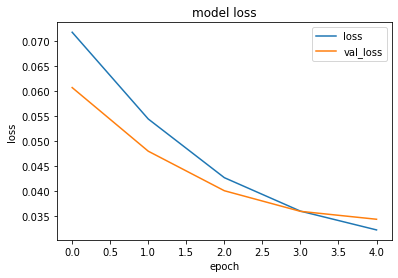

In [852]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"],label='loss')
plt.plot(history.history["val_loss"],label='val_loss')
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(loc="upper right")
plt.show()

In [853]:
preds = model.predict(X_test.values).flatten()
preds[:5]

557/557 [==============================] - 0s 607us/step


array([0.47994733, 0.6606416 , 0.5087935 , 0.53147244, 0.8382554 ],
      dtype=float32)

MSE is interpreted as an error metric where the closer the value is to 0, the more accurate the model is. Here, the results are optimistic.

In [854]:
print('Score:', mean_squared_error(y_test, preds))

Score: 0.032242574878558285


## 6. Select k best recommendations

#### In this step, we take advantage of the recommendation engine we just created so as to select the best 3 product recommendations for a randomly chosen order.

Finally we are ready to see the actual results our recommendation system. Each time we randomly get a different order_id and we produce its revelant recommendations. To clarify, we pay attention to the order and item encodings as we should give the proper input to our ML model in order to receive the desired predictions.

In [855]:
order2order_encoded = {x: i for i, x in enumerate(order_ids)}
item2item_encoded = {x: i for i, x in enumerate(item_ids)}
item_encoded2item = {i: x for i, x in enumerate(item_ids)}

In [856]:

# Let us get an order and see the top recommendations.
ord_id = df.order_id.sample(1).iloc[0]
items_in_order = df[df.order_id == ord_id]
items_not_in_basket = df[
    ~df["product_identifier"].isin(items_in_order.product_identifier.values)
]["product_identifier"]
items_not_in_basket = list(
    set(items_not_in_basket).intersection(set(item2item_encoded.keys()))
)
items_not_in_basket = [[item2item_encoded.get(x)] for x in items_not_in_basket]
order_encoder = order2order_encoded.get(ord_id)
order_item_array = np.hstack(
    ([[order_encoder]] * len(items_not_in_basket), items_not_in_basket)
)
ratings = model.predict(order_item_array).flatten()
top_ratings_indices = ratings.argsort()[-80:][::-1]
recommended_item_ids = [
    item_encoded2item.get(items_not_in_basket[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for order: {}".format(ord_id))
print("====" * 9)
print("----" * 8)
print("Top item recommendations")
print("----" * 8)
recommended_items = df[df["product_identifier"].isin(recommended_item_ids)]
recommended_items = recommended_items[['level_initial','product_identifier','item_name']]
recommended_items.drop_duplicates(subset=['product_identifier'],inplace = True)
for row in recommended_items.itertuples():
    print(row.item_name)

193/193 [==============================] - 0s 609us/step
Showing recommendations for order: aa241614-a380-4692-8408-82b76ae1b9ce
--------------------------------
Top item recommendations
--------------------------------
Smooth Gel Ink Ballpoint Pen 0.5Mm
Gel Ink Ballpoint Pen 0.7Mm
Aluminium Ruler
Eva Zip Case A5
Cotton Buds Refill X 200
Tin Candle - Hinoki Wood
Tin Candle - Elderflower
Gel Ink Ballpoint Pen 0.38Mm
Gel Ink Ballpoint Pen 0.38Mm
Smooth Gel Ink Ballpoint Pen 0.5Mm
Gel Ink Ballpoint Cap Type Pen - Set OF 10 (0.38)
Pencil Sharpener
0.5M Mechanical Pencil
Frosted Flip Top Bottle - 100Ml
6-In-1 Colour Pen
Gel Ink Ballpoint Pen 0.38Mm
Refill Gel Ink Ballpoint Pen 0.38Mm
Unbleached Cotton Pads 180 (60X50Mm)
Refill Smooth Gel Ink Ballpoint Pen 0.5Mm
Gel Ink Ballpoint Pen 0.38Mm
Thin Cotton Buds X 200
Thin Cotton Buds Refill X 200
PP Pen Case
Polyethylene Tube 30G
Polycarbonate Double Ruler
Gel Ink Ballpoint Pen 0.5Mm
Refill Gel Ink Ballpoint Pen 0.5Mm
PP Vanity Case - 1/2
Tin Ca

In [857]:
recommended_items

,level_initial,product_identifier,item_name
161,2,4550002794118,Smooth Gel Ink Ballpoint Pen 0.5Mm
1632,18,4550002796891,Gel Ink Ballpoint Pen 0.7Mm
2301,26,4550002555764,Aluminium Ruler
2587,30,4550002873585,Eva Zip Case A5
3105,36,4547315570386,Cotton Buds Refill X 200
...,...,...,...
74928,17409,4550002814526,Refill Gel Ink Ballpoint Pen 0.7Mm
81595,44953,4550344594261,Polypropylene Cream Container/M
82154,46514,4550344594278,PP Cream Pot L
84109,57286,4550344872659,Ricarica Per Penna A Sfera Con Inchiostro Gel ...


Here we can search the randomly selected order id within the df dataframe and see its items.

In [858]:
df[df.order_id == ord_id]

,level_initial,completion_date,product_identifier,order_id,item_name,price,store_name,extra_data,Record Count,cat1,cat2,cat3,combined,combined2,Date,Time Bin,count_time_bin,weekofyear,count_week,metric_week,metric_time,score,order,item
21407,63335,"Mar 5, 2023, 4:56:00/PM",4550344902769,aa241614-a380-4692-8408-82b76ae1b9ce,PP Suspension File Box,5.95,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1,"""categories"": [""Stationery""","""Organisation""","""Desk Storage & Box Files""]","""Stationery""_""Organisation""_""Desk Storage & B...","""Stationery""_""Organisation""",2023-03-05 16:56:00,15:00:00-17:59:59,16,10,4,4,5,0.425,14695,184
46611,63332,"Mar 5, 2023, 4:56:00/PM",4550002469245,aa241614-a380-4692-8408-82b76ae1b9ce,High Quality Paper Open-Flat Notebook A6,4.50,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1,"""categories"": [""Stationery""","""Notebooks & Paper""","""Ruled Notebooks""]","""Stationery""_""Notebooks & Paper""_""Ruled Noteb...","""Stationery""_""Notebooks & Paper""",2023-03-05 16:56:00,15:00:00-17:59:59,65,10,7,5,8,0.650,14695,674
61525,63330,"Mar 5, 2023, 4:56:00/PM",4548718959402,aa241614-a380-4692-8408-82b76ae1b9ce,Lens Cleaning Cloths X 14,1.95,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Beauty"",...",1,"""categories"": [""Beauty""","""Beauty Accessories""","""Make-Up Brushes & Tools""]","""Beauty""_""Beauty Accessories""_""Make-Up Brushe...","""Beauty""_""Beauty Accessories""",2023-03-05 16:56:00,15:00:00-17:59:59,43,10,17,7,7,0.750,14695,1284
61805,63331,"Mar 5, 2023, 4:56:00/PM",4934761390697,aa241614-a380-4692-8408-82b76ae1b9ce,White Porcelain Tray,7.95,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1,"""categories"": [""Home""","""Decor & Accessories""","""Bathroom Accessories""]","""Home""_""Decor & Accessories""_""Bathroom Access...","""Home""_""Decor & Accessories""",2023-03-05 16:56:00,15:00:00-17:59:59,21,10,3,3,6,0.400,14695,514
74053,63333,"Mar 5, 2023, 4:56:00/PM",4550344902783,aa241614-a380-4692-8408-82b76ae1b9ce,PP File Box Wide 1/2,4.95,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1,"""categories"": [""Stationery""","""Organisation""","""Desk Storage & Box Files""]","""Stationery""_""Organisation""_""Desk Storage & B...","""Stationery""_""Organisation""",2023-03-05 16:56:00,15:00:00-17:59:59,5,10,1,1,3,0.100,14695,1260
74599,63334,"Mar 5, 2023, 4:56:00/PM",4550344902745,aa241614-a380-4692-8408-82b76ae1b9ce,File Box 1/2,3.95,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1,"""categories"": [""Stationery""","""Organisation""","""Desk Storage & Box Files""]","""Stationery""_""Organisation""_""Desk Storage & B...","""Stationery""_""Organisation""",2023-03-05 16:56:00,15:00:00-17:59:59,6,10,4,4,4,0.375,14695,426


We print all the unique store names. From their description, we understand that most of them are in UK.

In [859]:
df.store_name.unique()

array([' COVENT GARDEN', ' MILANO CORSO BUENOS AIRES', ' CARNABY STREET',
       ' ISLINGTON', ' ZURICH GLATT FLAGSHIP', ' TOTTENHAM COURT ROAD',
       ' OXFORD STREET', ' ILLUM COPENHAGEN', ' KENSINGTON',
       ' BIRMINGHAM', ' AHLENS CITY STOCKHOLM'], dtype=object)

We keep the store name so as to know the store where the selected order was recorded. This information will be useful later on.

In [860]:
store_desc = df.loc[df['order_id'] == ord_id, 'store_name'].iloc[0]
store_desc

' ISLINGTON'

In [861]:
recommended_items = recommended_items.reset_index(drop=True)
recommended_items

,level_initial,product_identifier,item_name
0,2,4550002794118,Smooth Gel Ink Ballpoint Pen 0.5Mm
1,18,4550002796891,Gel Ink Ballpoint Pen 0.7Mm
2,26,4550002555764,Aluminium Ruler
3,30,4550002873585,Eva Zip Case A5
4,36,4547315570386,Cotton Buds Refill X 200
...,...,...,...
75,17409,4550002814526,Refill Gel Ink Ballpoint Pen 0.7Mm
76,44953,4550344594261,Polypropylene Cream Container/M
77,46514,4550344594278,PP Cream Pot L
78,57286,4550344872659,Ricarica Per Penna A Sfera Con Inchiostro Gel ...


By taking advantage of the large dataset, we concluded in n recommendations. However, we should check whether the recommended items were sold at least once in the store of our interest. It is obvious that it has no value to recommend items that are sold in other stores that belong to the same retail chain.

In [862]:
for i in range(len(recommended_items.index)):
    if ((df['product_identifier'] == recommended_items['product_identifier'][i]) & (df['store_name'] == store_desc)).any():
        continue
    else:
        recommended_items = recommended_items.drop(index=i)
recommended_items
        

,level_initial,product_identifier,item_name
0,2,4550002794118,Smooth Gel Ink Ballpoint Pen 0.5Mm
1,18,4550002796891,Gel Ink Ballpoint Pen 0.7Mm
2,26,4550002555764,Aluminium Ruler
3,30,4550002873585,Eva Zip Case A5
4,36,4547315570386,Cotton Buds Refill X 200
...,...,...,...
75,17409,4550002814526,Refill Gel Ink Ballpoint Pen 0.7Mm
76,44953,4550344594261,Polypropylene Cream Container/M
77,46514,4550344594278,PP Cream Pot L
78,57286,4550344872659,Ricarica Per Penna A Sfera Con Inchiostro Gel ...


We should act proactively and take into consideration possible exceptions. In case most of the recommended items are not sold in the store of our interest (probably due to limited number of order ids referring to this store), we randomly pick a few products sold in this store.

In [863]:
if len(recommended_items) < 6:
    df_temp = df[df.store_name == store_desc]
    recommended_items = df_temp.sample(n = 5)

Off course, we do not end here. The dataset owner ask from us to create a recommendation system that produces only 3 product recommendations. Our goal now is to narrow down the n recommendations about each order id. At this point we would like to make 2 basic notes:

1. As a great number of orders have to do with stationery products, we are expected to see recommendations about relevant products such as gel inks on every order. By default, that is not wrong and it should not make us skeptical. There are 2 possible scenarios: a. the dataset is not representative and if we access more data this effect will be decreased b. the retailer's physical stores are renowned for their stationery products and, to some context, we should also promote them via our recommendation engine (based on a business perspective). So, it would make sense to decide to recommend always a stationery product (1 out of 3 recommended products) and just then focus on the other 2 products.

2. By continuing the last sentence of Note 1, if we want to conclude to just 2 recommendations out of several ones that we already have, we can take into account the product category feature that was neglected before. However, we should do that gently by avoiding manual actions.

We go for the first recommended item, the popular one. In fact, we select the first 5 products that our ML model predicted amd we randomly choose one of them as our 1rst recommended product.

In [864]:
top_ratings_indices_1 = ratings.argsort()[-5:][::-1]
recommended_item_ids_1 = [
    item_encoded2item.get(items_not_in_basket[x][0]) for x in top_ratings_indices_1
]
recommended_item_1 = df[df["product_identifier"].isin(recommended_item_ids_1)]
recommended_item_1.drop_duplicates(subset=['product_identifier'],inplace = True)
recommended_item_1 = recommended_item_1[['level_initial','product_identifier','item_name']]
for row in recommended_item_1.itertuples():
    print(row.item_name, row.product_identifier)


Smooth Gel Ink Ballpoint Pen 0.5Mm 4550002794118
Tin Candle - Hinoki Wood 5055473366851
Gel Ink Ballpoint Pen 0.38Mm 4550002794262
Gel Ink Ballpoint Pen 0.5Mm 4550002796815
B5 Notebooks 5 Pack 4548076316145


In [865]:
recommended_item_1 = recommended_item_1.sample()
recommended_item_1

,level_initial,product_identifier,item_name
34680,723,4548076316145,B5 Notebooks 5 Pack


In order to search and find the other 2 recommended items, we just delete the first selected item from the "recommended_items" dataset.

In [866]:
index_init = recommended_item_1.iloc[0]['level_initial']

In [867]:
i = recommended_items[(recommended_items.level_initial == index_init)].index

In [868]:
recommended_items.drop(i, inplace = True)
recommended_items

,level_initial,product_identifier,item_name
0,2,4550002794118,Smooth Gel Ink Ballpoint Pen 0.5Mm
1,18,4550002796891,Gel Ink Ballpoint Pen 0.7Mm
2,26,4550002555764,Aluminium Ruler
3,30,4550002873585,Eva Zip Case A5
4,36,4547315570386,Cotton Buds Refill X 200
...,...,...,...
75,17409,4550002814526,Refill Gel Ink Ballpoint Pen 0.7Mm
76,44953,4550344594261,Polypropylene Cream Container/M
77,46514,4550344594278,PP Cream Pot L
78,57286,4550344872659,Ricarica Per Penna A Sfera Con Inchiostro Gel ...


Now we are interested in the product category feature. We will take advantage of the dataframe columns that we created in the "A-priori" phase of our analysis.

In [869]:
recommended_items = recommended_items.reset_index(drop=True)
recommended_items

,level_initial,product_identifier,item_name
0,2,4550002794118,Smooth Gel Ink Ballpoint Pen 0.5Mm
1,18,4550002796891,Gel Ink Ballpoint Pen 0.7Mm
2,26,4550002555764,Aluminium Ruler
3,30,4550002873585,Eva Zip Case A5
4,36,4547315570386,Cotton Buds Refill X 200
...,...,...,...
74,17409,4550002814526,Refill Gel Ink Ballpoint Pen 0.7Mm
75,44953,4550344594261,Polypropylene Cream Container/M
76,46514,4550344594278,PP Cream Pot L
77,57286,4550344872659,Ricarica Per Penna A Sfera Con Inchiostro Gel ...


In [870]:
items_in_order = items_in_order.reset_index(drop=True)
items_in_order

,level_initial,completion_date,product_identifier,order_id,item_name,price,store_name,extra_data,Record Count,cat1,cat2,cat3,combined,combined2,Date,Time Bin,count_time_bin,weekofyear,count_week,metric_week,metric_time,score,order,item
0,63335,"Mar 5, 2023, 4:56:00/PM",4550344902769,aa241614-a380-4692-8408-82b76ae1b9ce,PP Suspension File Box,5.95,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1,"""categories"": [""Stationery""","""Organisation""","""Desk Storage & Box Files""]","""Stationery""_""Organisation""_""Desk Storage & B...","""Stationery""_""Organisation""",2023-03-05 16:56:00,15:00:00-17:59:59,16,10,4,4,5,0.425,14695,184
1,63332,"Mar 5, 2023, 4:56:00/PM",4550002469245,aa241614-a380-4692-8408-82b76ae1b9ce,High Quality Paper Open-Flat Notebook A6,4.50,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1,"""categories"": [""Stationery""","""Notebooks & Paper""","""Ruled Notebooks""]","""Stationery""_""Notebooks & Paper""_""Ruled Noteb...","""Stationery""_""Notebooks & Paper""",2023-03-05 16:56:00,15:00:00-17:59:59,65,10,7,5,8,0.650,14695,674
2,63330,"Mar 5, 2023, 4:56:00/PM",4548718959402,aa241614-a380-4692-8408-82b76ae1b9ce,Lens Cleaning Cloths X 14,1.95,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Beauty"",...",1,"""categories"": [""Beauty""","""Beauty Accessories""","""Make-Up Brushes & Tools""]","""Beauty""_""Beauty Accessories""_""Make-Up Brushe...","""Beauty""_""Beauty Accessories""",2023-03-05 16:56:00,15:00:00-17:59:59,43,10,17,7,7,0.750,14695,1284
3,63331,"Mar 5, 2023, 4:56:00/PM",4934761390697,aa241614-a380-4692-8408-82b76ae1b9ce,White Porcelain Tray,7.95,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Home"", ""...",1,"""categories"": [""Home""","""Decor & Accessories""","""Bathroom Accessories""]","""Home""_""Decor & Accessories""_""Bathroom Access...","""Home""_""Decor & Accessories""",2023-03-05 16:56:00,15:00:00-17:59:59,21,10,3,3,6,0.400,14695,514
4,63333,"Mar 5, 2023, 4:56:00/PM",4550344902783,aa241614-a380-4692-8408-82b76ae1b9ce,PP File Box Wide 1/2,4.95,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1,"""categories"": [""Stationery""","""Organisation""","""Desk Storage & Box Files""]","""Stationery""_""Organisation""_""Desk Storage & B...","""Stationery""_""Organisation""",2023-03-05 16:56:00,15:00:00-17:59:59,5,10,1,1,3,0.100,14695,1260
5,63334,"Mar 5, 2023, 4:56:00/PM",4550344902745,aa241614-a380-4692-8408-82b76ae1b9ce,File Box 1/2,3.95,ISLINGTON,"{""vat_rate"": ""20.00"", ""categories"": [""Statione...",1,"""categories"": [""Stationery""","""Organisation""","""Desk Storage & Box Files""]","""Stationery""_""Organisation""_""Desk Storage & B...","""Stationery""_""Organisation""",2023-03-05 16:56:00,15:00:00-17:59:59,6,10,4,4,4,0.375,14695,426


Firstly, we search whether there are 2 items in the "recommended_items" dataframe that have the same absolut product category path with at least one of the items found in the selected order. 

In [871]:
recommended_item_2 = None
recommended_item_3 = None
index_2 = None
index_3 = None

for i in range(len(items_in_order.index)):
    for y in range(len(recommended_items.index)):
        try:
            x = recommended_items['level_initial'][y]
            z = items_in_order['level_initial'][i]
            cat_x = df.loc[df['level_initial'] == x, 'combined'].iloc[0]
            cat_z = df.loc[df['level_initial'] == z, 'combined'].iloc[0]
        except IndexError:
            continue
        if cat_x == cat_z:
            if recommended_item_2 is None:
                recommended_item_2 = recommended_items.iloc[y]
                index_2 = y
            else:
                recommended_item_3 = recommended_items.iloc[y]
                index_3 = y

if index_2 is not None:
    recommended_items = recommended_items.drop(index=index_2)
if index_3 is not None:
    recommended_items = recommended_items.drop(index=index_3)

In [872]:
recommended_items = recommended_items.reset_index(drop=True)
recommended_items

,level_initial,product_identifier,item_name
0,2,4550002794118,Smooth Gel Ink Ballpoint Pen 0.5Mm
1,18,4550002796891,Gel Ink Ballpoint Pen 0.7Mm
2,26,4550002555764,Aluminium Ruler
3,30,4550002873585,Eva Zip Case A5
4,36,4547315570386,Cotton Buds Refill X 200
...,...,...,...
72,17409,4550002814526,Refill Gel Ink Ballpoint Pen 0.7Mm
73,44953,4550344594261,Polypropylene Cream Container/M
74,46514,4550344594278,PP Cream Pot L
75,57286,4550344872659,Ricarica Per Penna A Sfera Con Inchiostro Gel ...


Secondly, we search whether there are 1 or 2 items (depending on the results of the previous cell executed) in the "recommended_items" dataframe that have the same but more generic product category path with at least one of the items found in the selected order.

In [873]:
index_2 = None
index_3 = None

for i in range(len(items_in_order.index)):
    for y in range(len(recommended_items.index)):
        try:
            x = recommended_items['level_initial'][y]
            z = items_in_order['level_initial'][i]
            cat_x = df.loc[df['level_initial'] == x, 'combined2'].iloc[0]
            cat_z = df.loc[df['level_initial'] == z, 'combined2'].iloc[0]
        except IndexError:
            continue
        if cat_x == cat_z:
            if recommended_item_2 is None:
                recommended_item_2 = recommended_items.iloc[y]
                index_2 = y
            elif recommended_item_3 is None:
                recommended_item_3 = recommended_items.iloc[y]
                index_3 = y

if index_2 is not None:
    recommended_items = recommended_items.drop(index=index_2)
if index_3 is not None:
    recommended_items = recommended_items.drop(index=index_3)

In [874]:
print(recommended_item_2, recommended_item_3)

level_initial                             177
product_identifier              4547315844449
item_name             Portable Eyelash Curler
Name: 31, dtype: object level_initial                             11366
product_identifier                4945247715224
item_name             Face Blotting Paper X 100
Name: 72, dtype: object


If we could not find 2 appropriate recommended items, we should suspect any possible linguistic effects. We keep only the product category names written in the language that is linked with the store of our interest.

In [875]:
if recommended_item_2 is None:
    df_store = df[df.store_name == store_desc]
    df_store = df_store[['level_initial','completion_date','product_identifier','order_id','item_name','price','store_name','combined','combined2']]
    index_2 = None
    index_3 = None

    for i in range(len(items_in_order.index)):
        for y in range(len(recommended_items.index)):
            try:
                x = recommended_items['product_identifier'][y]
                z = items_in_order['level_initial'][i]
                cat_x = df_store.loc[df_store['product_identifier'] == x, 'combined'].iloc[0]
                cat_z = df_store.loc[df_store['level_initial'] == z, 'combined'].iloc[0]
            except IndexError:
                continue
            if cat_x == cat_z:
                if recommended_item_2 is None:
                    recommended_item_2 = recommended_items.iloc[y]
                    index_2 = y
                else:
                    recommended_item_3 = recommended_items.iloc[y]
                    index_3 = y

    if index_2 is not None:
        recommended_items = recommended_items.drop(index=index_2)
    if index_3 is not None:
        recommended_items = recommended_items.drop(index=index_3)
    else:
        index_2 = None
        index_3 = None
        for i in range(len(items_in_order.index)):
            for y in range(len(recommended_items.index)):
                try:
                    x = recommended_items['product_identifier'][y]
                    z = items_in_order['level_initial'][i]
                    cat_x = df_store.loc[df_store['product_identifier'] == x, 'combined2'].iloc[0]
                    cat_z = df_store.loc[df_store['level_initial'] == z, 'combined2'].iloc[0]
                except IndexError:
                    continue
                if cat_x == cat_z:
                    if recommended_item_2 is None:
                        recommended_item_2 = recommended_items.iloc[y]
                        index_2 = y
                    else:
                        recommended_item_3 = recommended_items.iloc[y]
                        index_3 = y 
        if index_2 is not None:
            recommended_items = recommended_items.drop(index=index_2)
        if index_3 is not None:
            recommended_items = recommended_items.drop(index=index_3)

In [876]:
print(recommended_item_2) 

level_initial                             177
product_identifier              4547315844449
item_name             Portable Eyelash Curler
Name: 31, dtype: object


In [877]:
print(recommended_item_3)

level_initial                             11366
product_identifier                4945247715224
item_name             Face Blotting Paper X 100
Name: 72, dtype: object


If this approach did not work out, we would just randomly select 1 or 2 items out of the 'recommended_items' dataset.

In [878]:
if recommended_item_2 is None:
    recommended_item_2 = recommended_items.sample()
    index_init = recommended_item_2.iloc[0]['level_initial']
    i = recommended_items[(recommended_items.level_initial == index_init)].index
    recommended_items.drop(i, inplace = True)
if recommended_item_3 is None:
    recommended_item_3 = recommended_items.sample()


In [879]:
print(recommended_item_1) 

       level_initial product_identifier            item_name
34680            723      4548076316145  B5 Notebooks 5 Pack


In [880]:
print(recommended_item_2) 

level_initial                             177
product_identifier              4547315844449
item_name             Portable Eyelash Curler
Name: 31, dtype: object


In [881]:
print(recommended_item_3)

level_initial                             11366
product_identifier                4945247715224
item_name             Face Blotting Paper X 100
Name: 72, dtype: object


## 7. Citations

* Ferreira, P.L., Han, Q. and Costeira, J.P. (2018) “The Effect of Product Placement on Shopping Behavior at the Point of Purchase: Evidence From Randomized Experiment Using Video Tracking in a Physical Bookstore,” Social Science Research Network (Preprint). Available at: <https://doi.org/10.2139/ssrn.3288604>.
* Kukreja, M. and Rashmi (2022) “Consumer’s Behaviour while Purchasing Apparels in Sale Period,” Management Dynamics, 16(1), pp. 1–40. Available at: <https://doi.org/10.57198/2583-4932.1072>.
* Park, J. and Nam, K. (2018) “Group recommender system for store product placement,” Data Mining and Knowledge Discovery, 33(1), pp. 204–229. Available at: <https://doi.org/10.1007/s10618-018-0600-z>.
* Thakker, U., Patel, R. and Shah, M. (2021) “A comprehensive analysis on movie recommendation system employing collaborative filtering,” Multimedia Tools and Applications, 80(19), pp. 28647–28672. Available at: <https://doi.org/10.1007/s11042-021-10965-2>.
* Team, K. Simple. flexible. powerful., Keras. Available at: https://keras.io/ (Accessed: 30 April 2023). 
